In [1]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
import itertools
from itertools import izip
import itertools
import os
import subprocess
import tempfile
import random

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib import pyplot
import matplotlib.patches as mpatches

import matplotlib as mpl
from matplotlib_venn import venn2, venn3
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/home/gpratt/Dropbox/mouse_stress/figures"

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#Factor this to a helpers function
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [3]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [4]:
names = {'hWT': 'WT/GT-hWT',
         'gt': 'WT/GT',
         'rev': 'WT/WT',
         "q331k": 'WT/GT-hQ331K'}

Abbreviations used to represent cell lines:
 
1. Revertant cells have two copies of wild type mTDP43.  Labeled as “Rev”
2. Gene trap cells have only one copy of wild type mTDP43.  Labeled as “GT”
3. Transgenic human wild type cells have one copy of wild type hTDP43 and one copy of wild type mTDP43.  Labeled as “WT” or “hWT”
4. Transgenic human mutant cells have one copy of Q331K mutant hTDP43 and one copy of wild type mTDP43.  Labeled as “Q331K” or “hQ331K”
 
There are 6 tubes labeled 4 May 2015, differentiated and treated together as one experiment:
* 1 stressed Rev, 1 control Rev
* 1 stressed hWT, 1 control hWT
* 1 stressed hQ331K, 1 control hQ331K
 
There are 16 tubes labeled 6 July 2015, differentiated and treated together as one experiment:
* 2 stressed GT, 2 control GT
* 2 stressed Rev, 2 control Rev
* 2 stressed hWT, 2 control hWT
* 2 stressed hQ331K, 2 control hQ331K

In [5]:
gene_id_to_name = region_helpers.gene_id_to_name("/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf.db")
ensembl_id_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

In [6]:
av_resequencing = parsers.rnaseq_metrics("/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/")

In [7]:
av_resequencing_filtered = av_resequencing[[ "Input Reads",
                            #"Reads After Triming",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            ]]

HTML(av_resequencing_filtered.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     } ))

In [8]:
av_resequencing_filtered.to_csv("/home/gpratt/Dropbox/Presentations/random_figures/av_qc_data.csv")

In [9]:
count_file = "/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/all_counts.txt"
count_df = pd.read_table(count_file, skiprows=1, index_col=0)
count_df.columns = [os.path.basename(item).split(".")[0] for item in count_df.columns]

rpkm_df = counts_to_rpkm(count_df).T
rpkm_df.columns = [item.split(".")[0] for item in rpkm_df.columns]
flotilla_rpkm_df = rpkm_df.copy()
!cp $count_file /home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/

In [10]:
count_df[count_df.columns[5:]].to_csv("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/important_counts.csv")

In [11]:
all_splicing_events = pd.read_csv("/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v2/combined_output/miso_summary_filtered.csv", index_col=[-2, 2, -1])

In [12]:
all_splicing_events.groupby(level=["sample_id", "splice_type"]).count().miso_posterior_mean.unstack()

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


splice_type                        A3SS  A5SS   MXE    RI     SE
sample_id                                                       
AV_cont_gt_a_S8_L007_R1_001        3789  2301   996  2477   9394
AV_cont_gt_b_S9_L007_R1_001        3869  2398  1001  2508   9638
AV_cont_hWT_A_S15_L008_R1_001      3763  2301  1005  2487   9368
AV_cont_hWT_b_S16_L008_R1_001      4129  2500  1076  2578  10022
AV_cont_q331k_A_S19_L008_R1_001    3833  2344  1010  2488   9476
AV_cont_q331k_b_S20_L008_R1_001    4006  2445  1040  2548   9815
AV_cont_rev_a_S12_L007_R1_001      3709  2307   981  2461   9275
AV_cont_rev_b_S13_L007_R1_001      3919  2406  1031  2531   9705
AV_q331k_S14_L007_R1_001           4201  2544  1059  2607  10140
AV_q331k_stress_S5_L006_R1_001     3886  2379  1002  2533   9459
AV_rev_S2_L006_R1_001              3872  2380   993  2535   9470
AV_rev_stress_S1_L006_R1_001       3683  2256   953  2472   8999
AV_stress_gt_a_S6_L006_R1_001      3862  2378  1008  2544   9554
AV_stress_gt_b_S7_L006_R1_001      3780  2382   980  2524   9420
AV_stress_hWT_A_S21_L008_R1_001    3500  2176   933  2423   8770
AV_stress_hWT_b_S22_L008_R1_001    3426  2126   913  2409   8551
AV_stress_q331K_A_S17_L008_R1_001  3431  2125   910  2377   8643
AV_stress_q331K_b_S18_L008_R1_001  3420  2118   902  1124   8537
AV_stress_rev_a_S10_L007_R1_001    3355  2102   909  2383   8387
AV_stress_rev_b_S11_L007_R1_001    3469  2178   929  2417   8719
AV_wt_S4_L006_R1_001               3827  2364   994  2522   9340
AV_wt_stress_S3_L006_R1_001        3836  2338  1005  2541   9359

In [13]:
all_splicing_events = pd.read_csv("/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/combined_output/miso_summary_filtered.csv", index_col=[-2, 2])
se_splicing_events = all_splicing_events[all_splicing_events.splice_type == "SE"]
splicing_df = se_splicing_events.groupby(level=["sample_id", "event_name"]).first().miso_posterior_mean.unstack().fillna(.5)

In [14]:
metadata = pd.DataFrame(index=splicing_df.index)
metadata['cell_type'] = "Mouse NPCs"
metadata['exp'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['stress'] = [True if "stress" in item else False for item in metadata.index]
metadata['phenotype'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['rep'] = [item.split("_")[3].lower() for item in metadata.index]
metadata['outlier'] = False
metadata['date'] = ["june" if ((item == "a") or (item == 'b')) else "may" for item in metadata.rep]
metadata.rep[~((metadata.rep == "a") | (metadata.rep == 'b'))] = 'a'

genotypes = ['gt', 'hWT', 'q331k', 'rev', 'wt']
result = []
for item in metadata.index:
    for genotype in genotypes:
        if genotype.lower() in item.lower():
            if genotype == 'wt':
                genotype = 'hWT'
            result.append(genotype)
            break
metadata['genotype'] = result
metadata['sample_id'] = metadata.index 

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
metadata.to_csv("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/SampleInfo.csv")

In [16]:
flotilla_rpkm_df

ENSMUSG00000090025  ENSMUSG00000064842  \
AV_cont_gt_a_S8_L007_R1_001                  0.000000                   0   
AV_cont_gt_b_S9_L007_R1_001                  0.000000                   0   
AV_cont_hWT_A_S15_L008_R1_001                0.000000                   0   
AV_cont_hWT_b_S16_L008_R1_001                0.000000                   0   
AV_cont_q331k_A_S19_L008_R1_001              0.000000                   0   
AV_cont_q331k_b_S20_L008_R1_001              0.000000                   0   
AV_cont_rev_a_S12_L007_R1_001                0.000000                   0   
AV_cont_rev_b_S13_L007_R1_001                0.000000                   0   
AV_q331k_S14_L007_R1_001                     0.033545                   0   
AV_q331k_stress_S5_L006_R1_001               0.000000                   0   
AV_rev_S2_L006_R1_001                        0.000000                   0   
AV_rev_stress_S1_L006_R1_001                 0.000000                   0   
AV_stress_gt_a_S6_L006_R1_001                0.000000                   0   
AV_stress_gt_b_S7_L006_R1_001                0.000000                   0   
AV_stress_hWT_A_S21_L008_R1_001              0.000000                   0   
AV_stress_hWT_b_S22_L008_R1_001              0.000000                   0   
AV_stress_q331K_A_S17_L008_R1_001            0.000000                   0   
AV_stress_q331K_b_S18_L008_R1_001            0.000000                   0   
AV_stress_rev_a_S10_L007_R1_001              0.000000                   0   
AV_stress_rev_b_S11_L007_R1_001              0.000000                   0   
AV_wt_S4_L006_R1_001                         0.000000                   0   
AV_wt_stress_S3_L006_R1_001                  0.000000                   0   

                                   ENSMUSG00000051951  ENSMUSG00000089699  \
AV_cont_gt_a_S8_L007_R1_001                  5.594013            0.290436   
AV_cont_gt_b_S9_L007_R1_001                  4.645654            0.000000   
AV_cont_hWT_A_S15_L008_R1_001                6.683514            1.994906   
AV_cont_hWT_b_S16_L008_R1_001                7.306760            0.102421   
AV_cont_q331k_A_S19_L008_R1_001              5.421284            0.000000   
AV_cont_q331k_b_S20_L008_R1_001              4.207473            0.185631   
AV_cont_rev_a_S12_L007_R1_001                5.730549            0.602103   
AV_cont_rev_b_S13_L007_R1_001                5.172243            1.084081   
AV_q331k_S14_L007_R1_001                     1.886360            0.268900   
AV_q331k_stress_S5_L006_R1_001               0.821791            0.674153   
AV_rev_S2_L006_R1_001                        2.821070            0.126177   
AV_rev_stress_S1_L006_R1_001                 0.329209            0.000000   
AV_stress_gt_a_S6_L006_R1_001                1.303517            0.432307   
AV_stress_gt_b_S7_L006_R1_001                0.948017            0.777702   
AV_stress_hWT_A_S21_L008_R1_001              0.296584            1.445907   
AV_stress_hWT_b_S22_L008_R1_001              0.262488            0.984371   
AV_stress_q331K_A_S17_L008_R1_001            0.547568            0.342244   
AV_stress_q331K_b_S18_L008_R1_001            0.295182            0.159897   
AV_stress_rev_a_S10_L007_R1_001              0.153040            2.008734   
AV_stress_rev_b_S11_L007_R1_001              0.331158            0.288297   
AV_wt_S4_L006_R1_001                         2.176821            1.409865   
AV_wt_stress_S3_L006_R1_001                  0.370552            0.860245   

                                   ENSMUSG00000088333  ENSMUSG00000025900  \
AV_cont_gt_a_S8_L007_R1_001                         0            0.053190   
AV_cont_gt_b_S9_L007_R1_001                         0            0.038873   
AV_cont_hWT_A_S15_L008_R1_001                       0            0.016607   
AV_cont_hWT_b_S16_L008_R1_001                       0            0.013642   
AV_cont_q331k_A_S19_L008_R1_001                     0            0.026777   
AV_cont_q331k_b_S20_L008_R1_0

In [17]:
mn_study_stress = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[metadata.date == "june"],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[metadata.date == "june"],
                       expression_thresh = 1,
                       species="mm10"
)

2016-02-15 10:42:02	Initializing Study
2016-02-15 10:42:02	Initializing Predictor configuration manager for Study
2016-02-15 10:42:02	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-15 10:42:02	Added ExtraTreesClassifier to default predictors
2016-02-15 10:42:02	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-15 10:42:02	Added ExtraTreesRegressor to default predictors
2016-02-15 10:42:02	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-15 10:42:02	Added GradientBoostingClassifier to default predictors
2016-02-15 10:42:02	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-02-15 10:42:02	Added GradientBoostingRegressor to default predictors
2016-02-15 10:42:02	Loading metadata
2016-02-15 10:42:03	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species mm10 data: HTTP Error 404: Not Found

https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-02-15 10:42:04	Loading expression data
2016-02-15 10:42:04	Initializing expression
2016-02-15 10:42:04	Done initializing expression
2016-02-15 10:42:05	Loading splicing data
2016-02-15 10:42:05	Initializing splicing
2016-02-15 10:42:05	Done initializing splicing
2016-02-15 10:42:05	Successfully initialized a Study object!


/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/data_model/metadata.py:188: UserWarning: MetaData.phenotype_series will be deprecated in 0.3.0
  warnings.warn('MetaData.phenotype_series will be deprecated in 0.3.0')
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:177: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  self.magnitudes.sort(ascending=False)
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:184: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  x.sort(ascending=True)
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


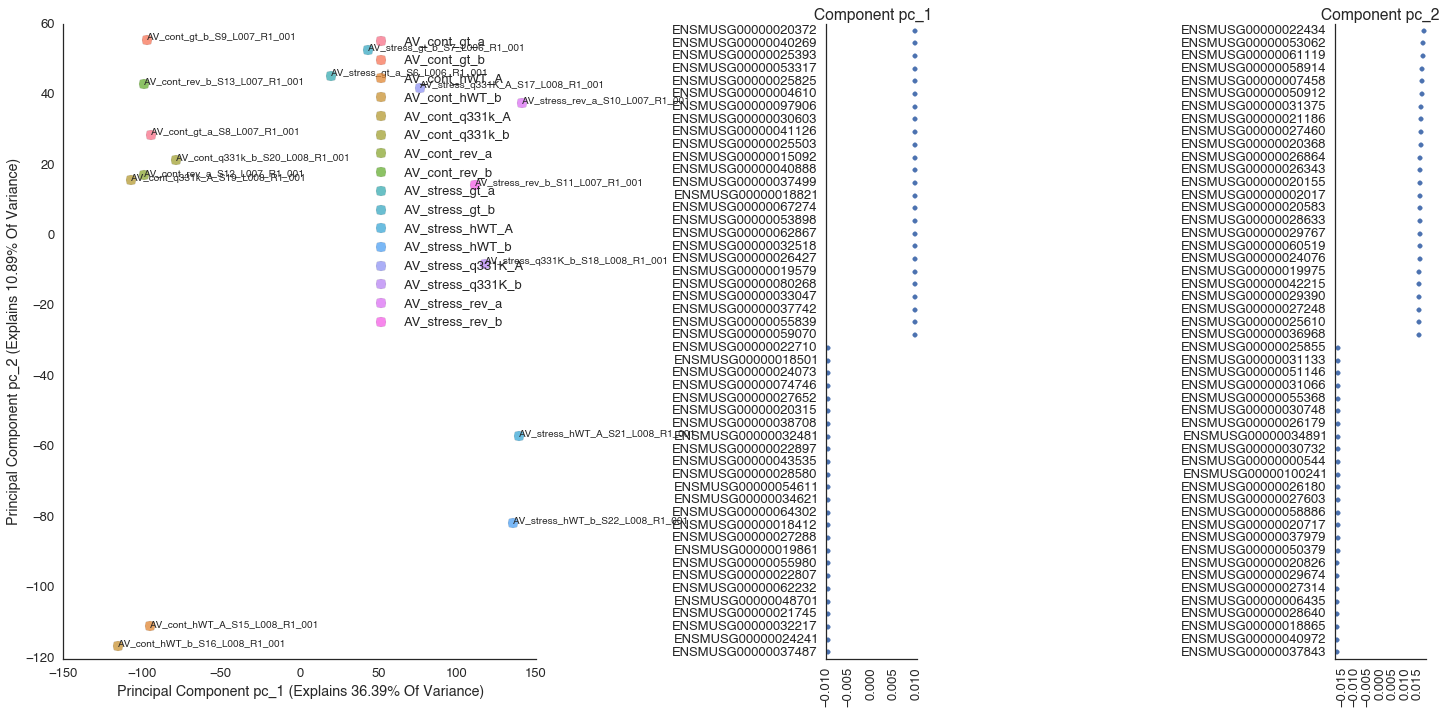

In [18]:
mn_study_stress.plot_pca(feature_subset="all", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "expression_pca.svg"))

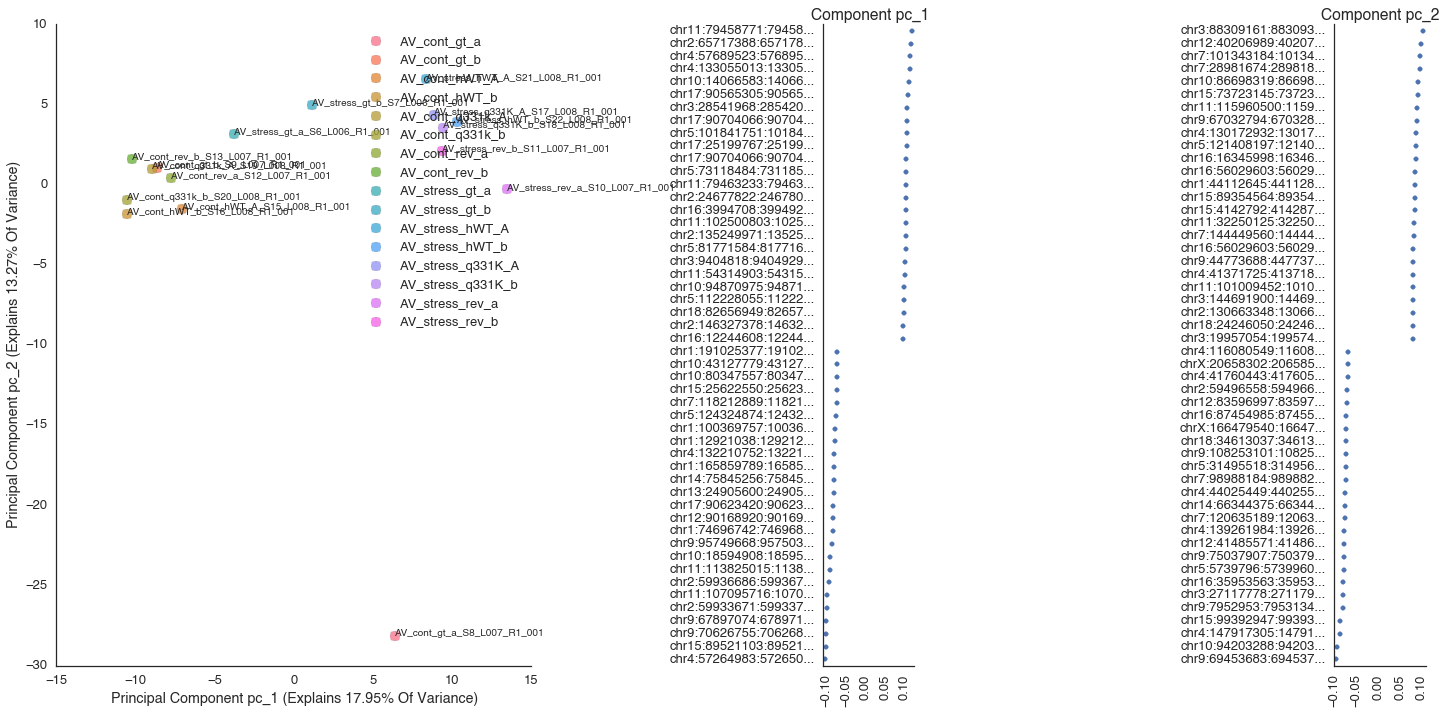

In [19]:
mn_study_stress.plot_pca(data_type="splicing", show_point_labels=True, show_vectors=False,)
pyplot.savefig(os.path.join(img_dir, "splicing_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "splicing_pca.svg"))

In [20]:
mn_study_unstressed = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[(metadata.date == "june") & ~metadata.stress ],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[(metadata.date == "june") & metadata.stress],
                       expression_thresh = 1,
                       species="mm10"
)

2016-02-15 10:42:26	Initializing Study
2016-02-15 10:42:26	Initializing Predictor configuration manager for Study
2016-02-15 10:42:26	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-15 10:42:26	Added ExtraTreesClassifier to default predictors
2016-02-15 10:42:26	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-15 10:42:26	Added ExtraTreesRegressor to default predictors
2016-02-15 10:42:26	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-15 10:42:26	Added GradientBoostingClassifier to default predictors
2016-02-15 10:42:26	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-02-15 10:42:26	Added GradientBoostingRegressor to default predictors
2016-02-15 10:42:26	Loading metadata
2016-02-15 10:42:26	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species mm10 data: HTTP Error 404: Not Found

https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-02-15 10:42:27	Loading expression data
2016-02-15 10:42:27	Initializing expression
2016-02-15 10:42:27	Done initializing expression
2016-02-15 10:42:28	Loading splicing data
2016-02-15 10:42:28	Initializing splicing
2016-02-15 10:42:28	Done initializing splicing
2016-02-15 10:42:28	Successfully initialized a Study object!


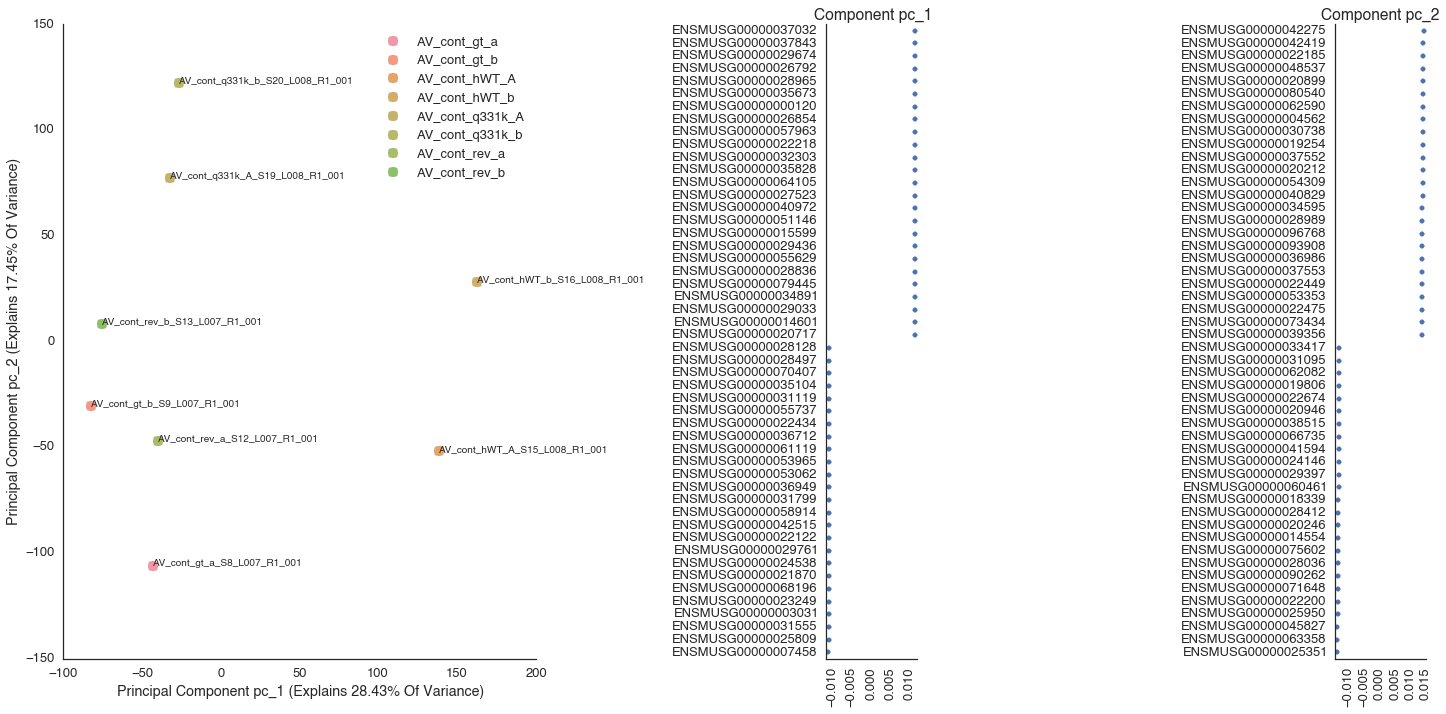

In [21]:
unstressed_pca = mn_study_unstressed.plot_pca(feature_subset="all", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_pca.svg"))

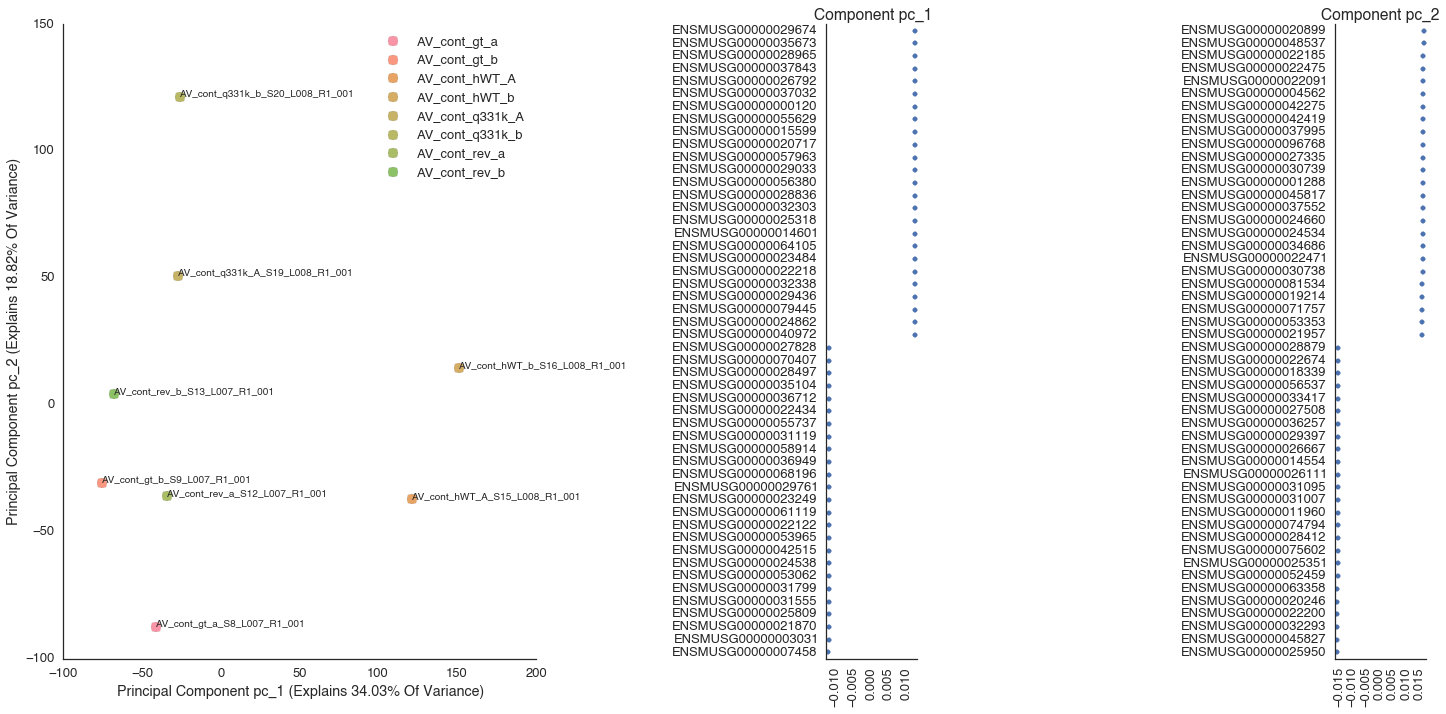

In [22]:
unstressed_protein_coding_pca = mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca.svg"))

In [23]:
len(unstressed_protein_coding_pca.components_.columns)

22078

In [24]:
len(set(unstressed_protein_coding_pca.components_.columns))

22078

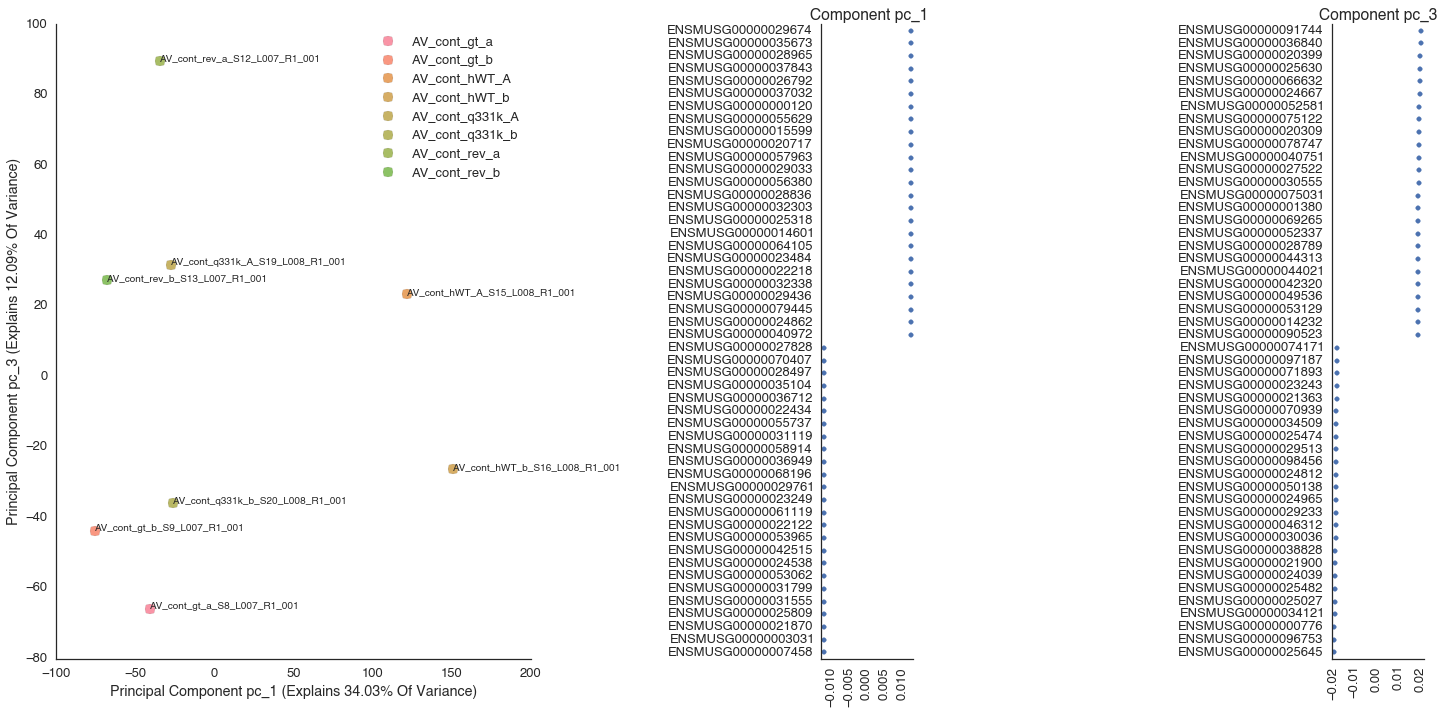

In [25]:
mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False,
                                                            x_pc=1,
                                                            y_pc=3)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_1-3.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_1-3.svg"))

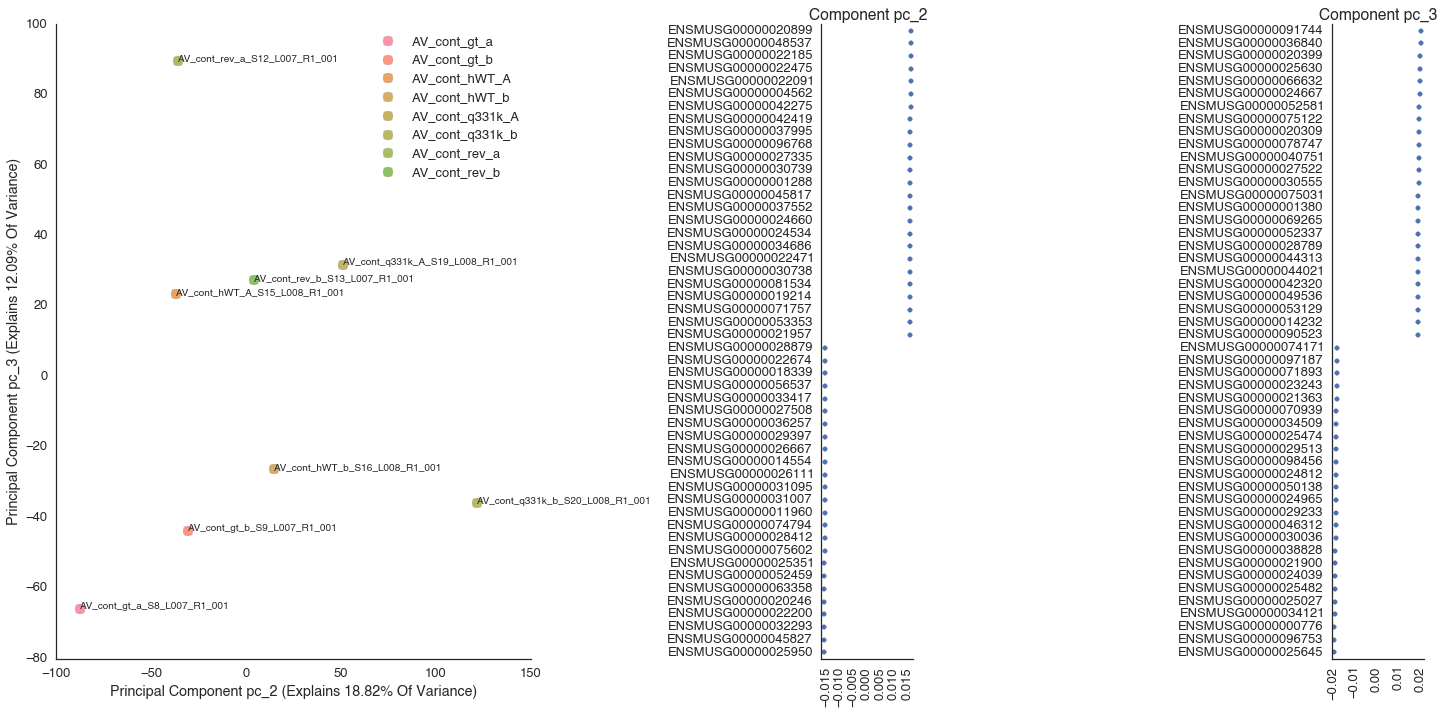

In [26]:
mn_study_unstressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False,
                                                            x_pc=2,
                                                            y_pc=3)
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_2-3.pdf"))
pyplot.savefig(os.path.join(img_dir, "unstressed_expression_protein_coding_pca_pc_2-3.svg"))

In [27]:
unstressed_protein_coding_pca.loadings

ENSMUSG00000028180  ENSMUSG00000028182  ENSMUSG00000028185  \
pc_1          -41.093837           -0.170190           27.699045   
pc_2           -1.445768          -17.779996           12.871180   

      ENSMUSG00000028184  ENSMUSG00000028187  ENSMUSG00000028186  \
pc_1           43.410124          -24.061801           11.043635   
pc_2          -14.024759          -20.574734          -19.611587   

      ENSMUSG00000028189  ENSMUSG00000028188  ENSMUSG00000035429  \
pc_1          -21.893131           -3.704744          -50.472732   
pc_2          -32.886539           14.234601           -5.469401   

      ENSMUSG00000035427         ...          ENSMUSG00000029587  \
pc_1           51.852223         ...                    9.284779   
pc_2           -5.771983         ...                   28.593945   

      ENSMUSG00000036951  ENSMUSG00000042672  ENSMUSG00000042671  \
pc_1          -18.121856           53.543154           46.623900   
pc_2            1.133940           11.200947           20.542666   

      ENSMUSG00000042670  ENSMUSG00000036955  ENSMUSG00000042675  \
pc_1          -11.507830           38.035337           47.925104   
pc_2          -19.417243            4.429983          -19.947181   

      ENSMUSG00000036959  ENSMUSG00000036958  ENSMUSG00000042678  
pc_1            5.599774                   0           17.314454  
pc_2           35.456113                   0          -15.468793  

[2 rows x 22078 columns]

In [28]:
#unstressed_protein_coding_pca.components_.columns = [ensembl_id_to_name[item] for item in unstressed_protein_coding_pca.components_]

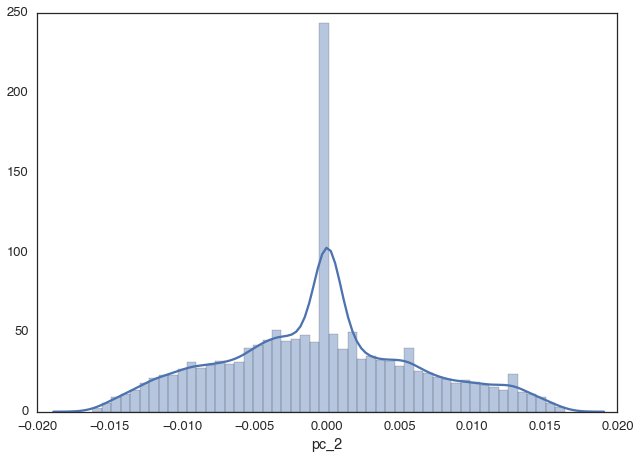

In [29]:
sns.distplot(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values())

In [30]:
mn_study_stressed = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = flotilla_rpkm_df[(metadata.date == "june") & metadata.stress ],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[(metadata.date == "june") & metadata.stress],
                       expression_thresh = 1,
                       species="mm10"
)

2016-02-15 10:43:17	Initializing Study
2016-02-15 10:43:17	Initializing Predictor configuration manager for Study
2016-02-15 10:43:17	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-15 10:43:17	Added ExtraTreesClassifier to default predictors
2016-02-15 10:43:17	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-15 10:43:17	Added ExtraTreesRegressor to default predictors
2016-02-15 10:43:17	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-15 10:43:17	Added GradientBoostingClassifier to default predictors
2016-02-15 10:43:17	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-02-15 10:43:17	Added GradientBoostingRegressor to default predictors
2016-02-15 10:43:17	Loading metadata
2016-02-15 10:43:17	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species mm10 data: HTTP Error 404: Not Found

2016-02-15 10:43:18	Loading expression data
2016-02-15 10:43:18	Initializing expression
2016-02-15 10:43:18	Done initializing expression
2016-02-15 10:43:19	Loading splicing data
2016-02-15 10:43:19	Initializing splicing
2016-02-15 10:43:19	Done initializing splicing
2016-02-15 10:43:19	Successfully initialized a Study object!


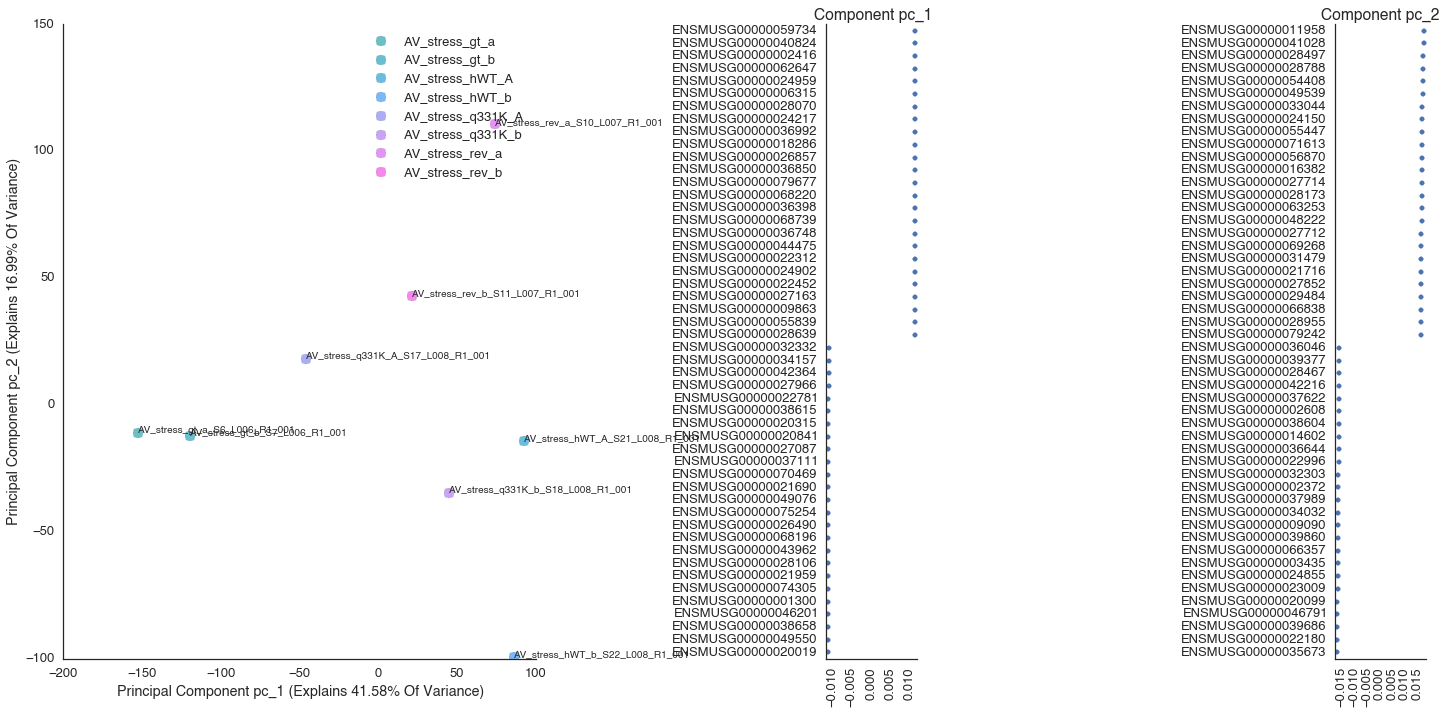

In [31]:
mn_study_stressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "stressed_expression_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "stressed_expression_pca.svg"))

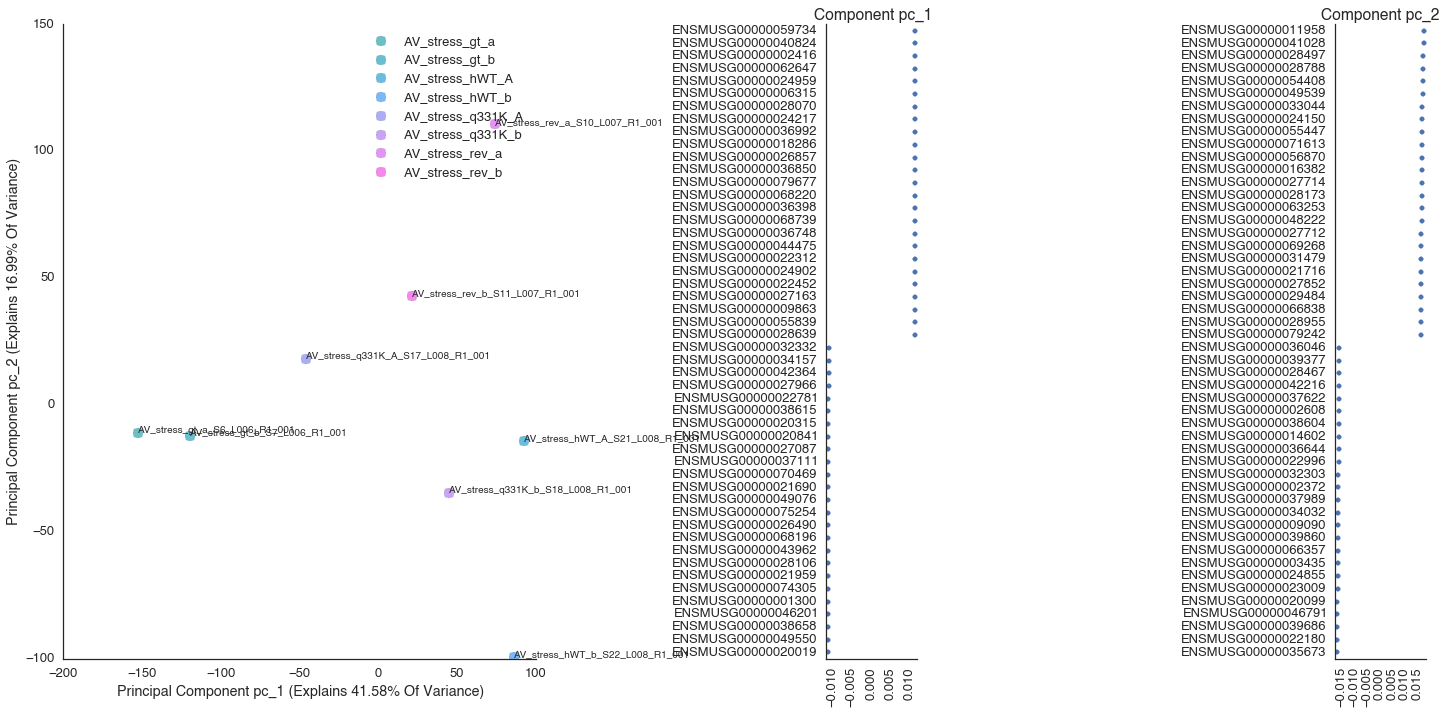

In [32]:
mn_study_stressed.plot_pca(feature_subset="gene_type: protein_coding", 
                             show_vectors=False, 
                             show_point_labels=True,
                             most_variant_features=False)
pyplot.savefig(os.path.join(img_dir, "stressed_expression_protein_coding_pca.pdf"))
pyplot.savefig(os.path.join(img_dir, "stressed_expression_protein_coding_pca.svg"))

#Look at Reproducablity between replicates

In [33]:
rpkm_df.index = pd.MultiIndex.from_arrays(np.array(metadata.T), names=metadata.columns)

In [34]:
r2_matrix = defaultdict(dict)
for y, (name1, name2) in enumerate(itertools.permutations(rpkm_df.index, 2)):
    series1 = rpkm_df.ix[name1]
    series2 = rpkm_df.ix[name2]
    r2_matrix[name1][name2] = scipy.stats.linregress(series1, series2)[2]
r2_matrix = pd.DataFrame(r2_matrix)
r2_matrix = r2_matrix.fillna(1)

In [35]:
#r2_matrix.index = ["_".join(item[:-4]) for item in  r2_matrix.index]
#r2_matrix.columns = ["_".join(item[:-4]) for item in  r2_matrix.columns]

In [36]:
sns.__version__

'0.6.0'

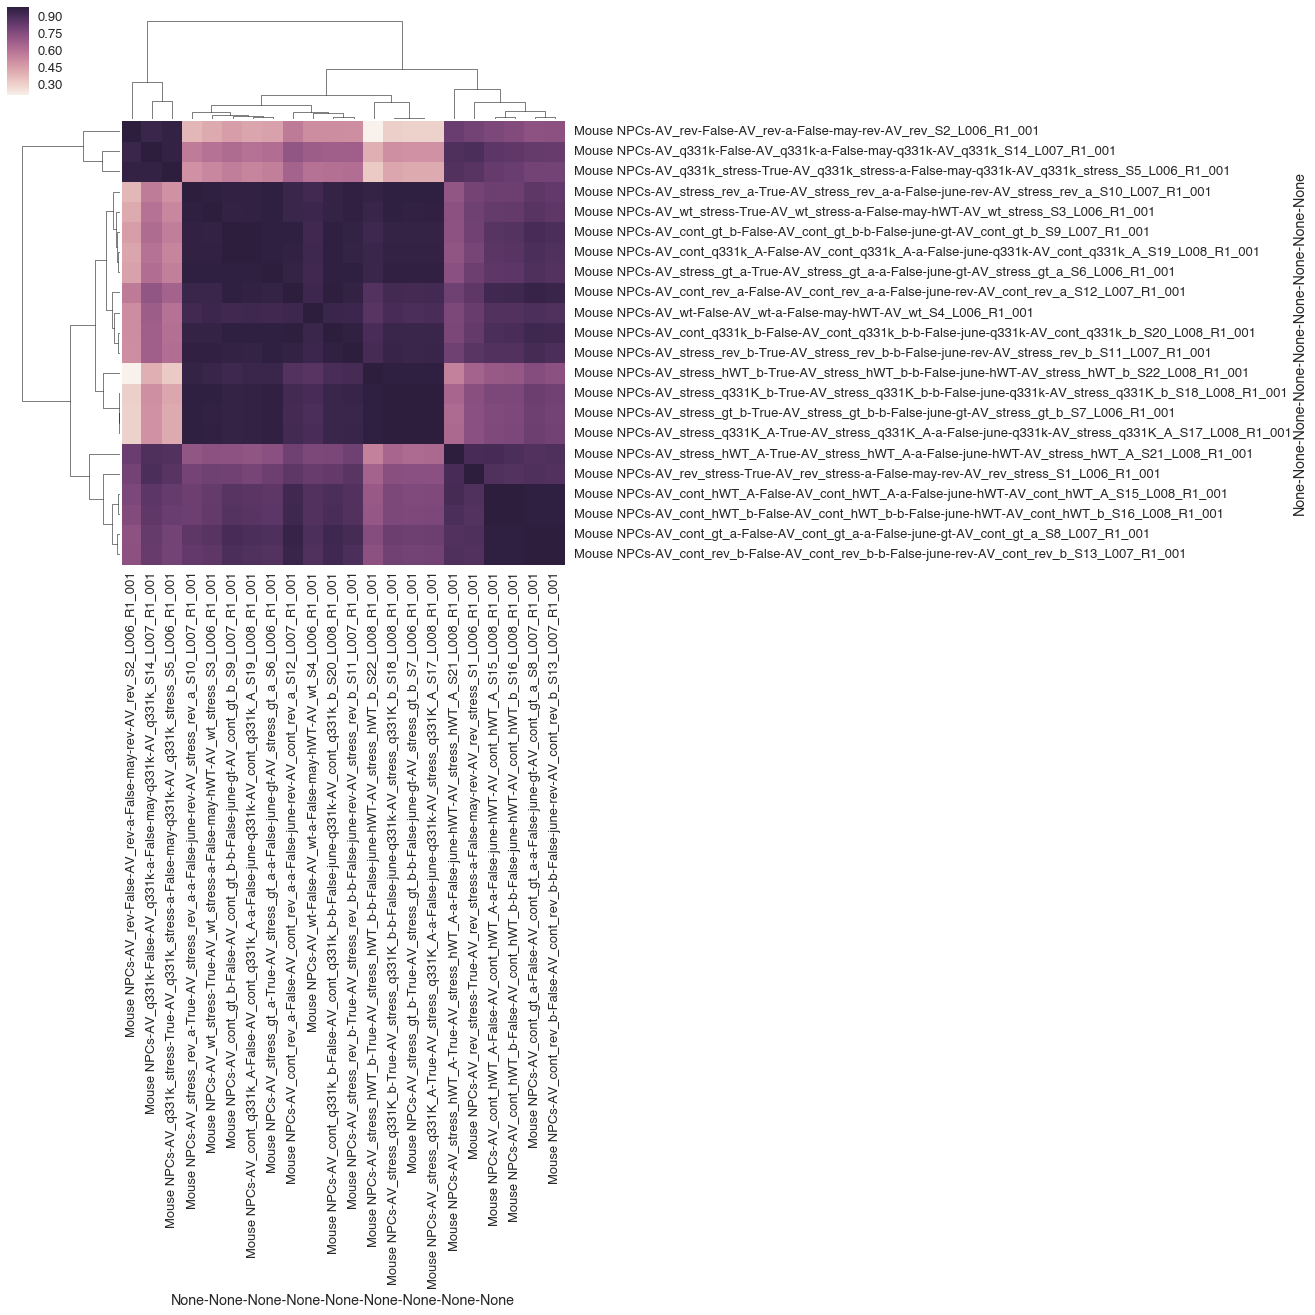

In [37]:
sns.clustermap(r2_matrix)
pyplot.savefig(os.path.join(img_dir, "correlation_clustergram.svg"))
pyplot.savefig(os.path.join(img_dir, "correlation_clustergram.pdf"))

8 3


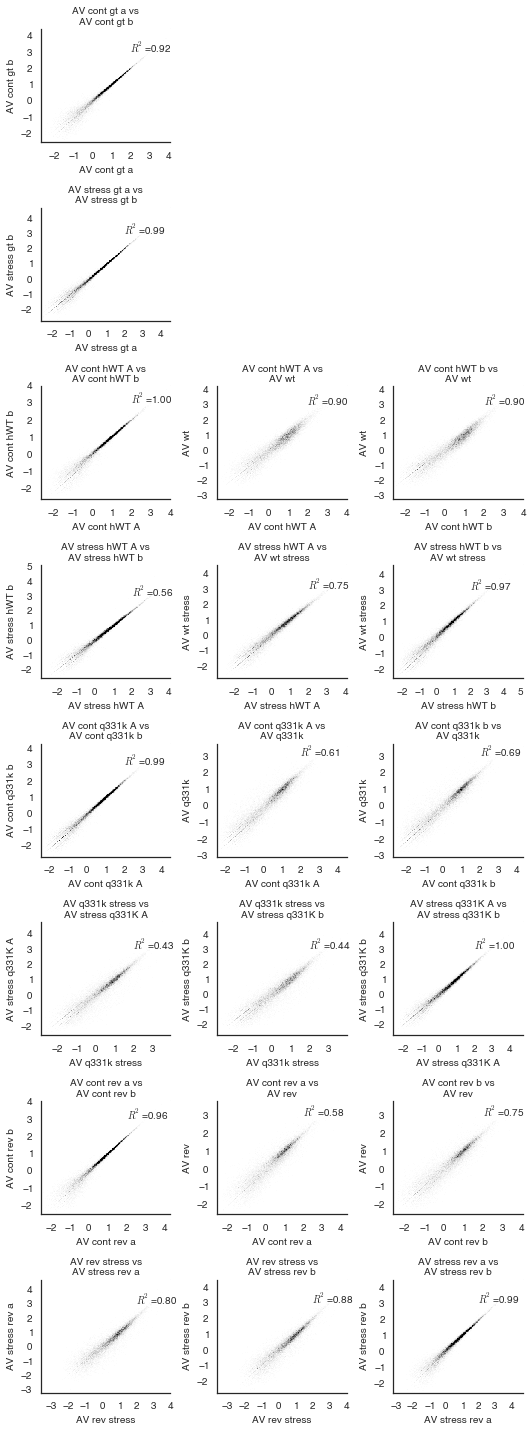

In [38]:
max_combinations = np.max(rpkm_df.groupby(level=["genotype", 'stress']).count().values)
num_rows = len(list(rpkm_df.groupby(level=["genotype", 'stress'])))
num_cols = len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(rpkm_df.groupby(level=["genotype", 'stress'])):
        for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):
            ax = fig.add_subplot(gs[x,y])
            series1 = rpkm_df.ix[name1]
            series2 = rpkm_df.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[-1].split("_")[:-4]))
            name2 = " ".join(map(str, name2[-1].split("_")[:-4]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=10)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

#look at reproducablity between stress vs un-stress conditions

4 9


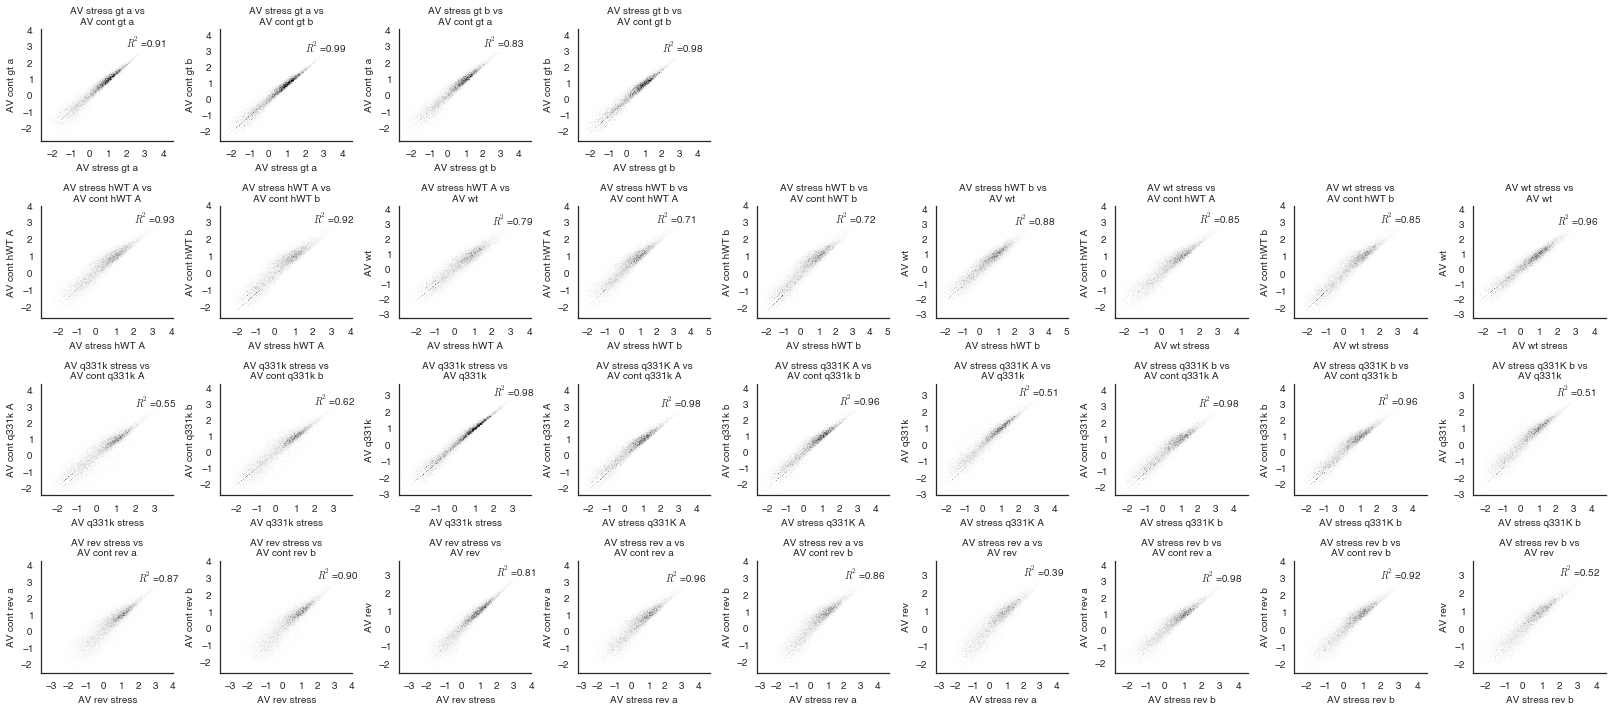

In [39]:
max_combinations = np.max(rpkm_df.groupby(level=["genotype"]).count().values)
num_rows = len(list(rpkm_df.groupby(level=["genotype"])))
num_cols = 9 #len(list(itertools.combinations(range(max_combinations), 2)))
print num_rows, num_cols 
with dataviz.Figure(os.path.join(img_dir, "stress_plotting.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, (name, group) in enumerate(rpkm_df.groupby(level=["genotype"])): 
        for y, (name1, name2) in enumerate(itertools.product(group.xs(True, level="stress", drop_level=False).index, group.xs(False, level="stress", drop_level=False).index)):
            ax = fig.add_subplot(gs[x,y])
            series1 = group.ix[name1]
            series2 = group.ix[name2]

            dataviz.loglog_hist2d(series1, series2, ax=ax)
            sns.despine(ax=ax)
            name1 = " ".join(map(str, name1[-1].split("_")[:-4]))
            name2 = " ".join(map(str, name2[-1].split("_")[:-4]))
            
            ax.set_xlabel(name1, fontsize=10)
            ax.set_ylabel(name2, fontsize=10)
            r2 = scipy.stats.linregress(series1, series2)[2]
            ax.text(2, 3, "$R^2$={:.2f}".format(r2))
            ax.set_title("{} vs\n{}".format(name1, name2), fontsize=10)
            [tick.set_fontsize(10) for tick in ax.get_xticklabels()]
            [tick.set_fontsize(10) for tick in ax.get_yticklabels()]

#Lets do some descriptives on differentally expressed genes

In [40]:
stress_vs_unstress = pd.concat({os.path.basename(item).split("_")[0]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/*stress.csv")}, names=["genotype", "gene_id"])
sig_stress_vs_unstress = stress_vs_unstress[(stress_vs_unstress.padj <= .05)  & (abs(stress_vs_unstress.log2FoldChange) > np.log2(1.5))]
sig_stress_vs_unstress_upregulated = sig_stress_vs_unstress[sig_stress_vs_unstress.log2FoldChange > 0]
sig_stress_vs_unstress_downregulated = sig_stress_vs_unstress[sig_stress_vs_unstress.log2FoldChange < 0]

In [41]:
pd.concat({"upregulated": sig_stress_vs_unstress_upregulated.groupby(level="genotype").count().baseMean,
           "downregulated": sig_stress_vs_unstress_downregulated.groupby(level="genotype").count().baseMean}).unstack()

genotype         gt   hWT  q331k   rev
downregulated  2651  4597   3849  4263
upregulated    1354  3712   2754  3269

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:238: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:239: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:240: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:241: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:242: FutureWarning: using '-' to provide set differen

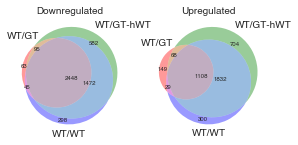

In [42]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['gt'].index,
                  sig_stress_vs_unstress_downregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_downregulated.ix['rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['gt'].index,
                  sig_stress_vs_unstress_upregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_upregulated.ix['rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

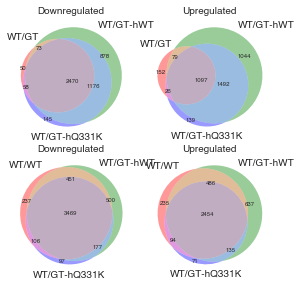

In [43]:
with dataviz.Figure(os.path.join(img_dir, "q311k_change.svg"), figsize=(4, 4)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['gt'].index,
                  sig_stress_vs_unstress_downregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_downregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "q331k")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,2)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['gt'].index,
                  sig_stress_vs_unstress_upregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_upregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "q331k")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(2,2,3)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['rev'].index,
                  sig_stress_vs_unstress_downregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_downregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("rev", "hWT", "q331k")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,4)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['rev'].index,
                  sig_stress_vs_unstress_upregulated.ix['hWT'].index,
                  sig_stress_vs_unstress_upregulated.ix['q331k'].index,],
            set_labels=map(lambda x: names[x], ("rev", "hWT", "q331k")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#How does Q331k Differ when directly compared to controls?

In [44]:
q331k_vs_ctrls = pd.concat({os.path.basename(item).split(".")[0]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/*stressed.csv")}, names=["genotype", "gene_id"])
result = []
for (exp, gene_id) in q331k_vs_ctrls.index:
    result.append((exp.split("_")[2], exp.split("_")[3], gene_id))
q331k_vs_ctrls.index = pd.MultiIndex.from_tuples(result, names=['ctrl', 'stress', 'gene_id'])

In [45]:
sig_q331k_vs_ctrls = q331k_vs_ctrls[(q331k_vs_ctrls.padj <= .05)  & (abs(q331k_vs_ctrls.log2FoldChange) > np.log2(1.5))]
sig_q331k_vs_ctrls_upregulated = sig_q331k_vs_ctrls[sig_q331k_vs_ctrls.log2FoldChange > 0]
sig_q331k_vs_ctrls_downregulated = sig_q331k_vs_ctrls[sig_q331k_vs_ctrls.log2FoldChange < 0]

In [46]:
differental_expression = pd.concat({"upregulated": sig_q331k_vs_ctrls_upregulated.groupby(level=["ctrl", 'stress']).count().baseMean,
           "downregulated": sig_q331k_vs_ctrls_downregulated.groupby(level=["ctrl", 'stress']).count().baseMean})

In [47]:
differental_expression.swaplevel(0,2).unstack().fillna(0)

downregulated  upregulated
stress     ctrl                            
stressed   gt             1017          196
           hWT             344          385
           rev              52           14
unstressed gt              823          810
           hWT             637          285
           rev             357          637

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


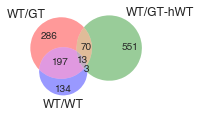

In [48]:
with dataviz.Figure(os.path.join(img_dir, "q331k_vs_control_change.svg"), figsize=(4, 4)) as fig:
    
    ax = fig.add_subplot(2,2,3)
    venn = venn3([set(sig_q331k_vs_ctrls_downregulated.ix['gt', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['hWT', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['rev', 'unstressed'].index),],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
                 ax=ax)

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  app.launch_new_instance()
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/gpratt/anaconda/lib/python2.7/site-packages/IPython

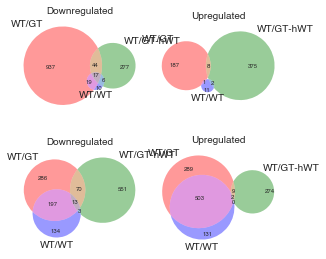

In [49]:
with dataviz.Figure(os.path.join(img_dir, "q331k_vs_control_change.svg"), figsize=(4, 4)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn = venn3([sig_q331k_vs_ctrls_downregulated.ix['gt', 'stressed'].index,
                  sig_q331k_vs_ctrls_downregulated.ix['hWT', 'stressed'].index,
                  sig_q331k_vs_ctrls_downregulated.ix['rev', 'stressed'].index,],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,2)
    venn = venn3([sig_q331k_vs_ctrls_upregulated.ix['gt', 'stressed'].index,
                  sig_q331k_vs_ctrls_upregulated.ix['hWT', 'stressed'].index,
                  sig_q331k_vs_ctrls_upregulated.ix['rev', 'stressed'].index,],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(2,2,3)
    venn = venn3([set(sig_q331k_vs_ctrls_downregulated.ix['gt', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['hWT', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_downregulated.ix['rev', 'unstressed'].index),],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(2,2,4)
    venn = venn3([set(sig_q331k_vs_ctrls_upregulated.ix['gt', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_upregulated.ix['hWT', 'unstressed'].index),
                  set(sig_q331k_vs_ctrls_upregulated.ix['rev', 'unstressed'].index),],
                 set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#Go Analysis

In [50]:
mm10GO = GO.GO(GOFile="/projects/ps-yeolab/genomes/mm10/mm10_ENSEMBL_TO_GO.txt.gz")

In [51]:
expressed_in_ctrl_but_not_q33k1_upregulated = (sig_stress_vs_unstress_upregulated.ix['rev'].index & sig_stress_vs_unstress_upregulated.ix['hWT'].index).difference(sig_stress_vs_unstress_upregulated.ix['q331k'].index)
expressed_in_ctrl_but_not_q33k1_downregulated = (sig_stress_vs_unstress_downregulated.ix['rev'].index & sig_stress_vs_unstress_downregulated.ix['hWT'].index).difference(sig_stress_vs_unstress_downregulated.ix['q331k'].index)

expressed_in_q331k_but_not_ctrl_upregulated = sig_stress_vs_unstress_upregulated.ix['q331k'].index.difference(sig_stress_vs_unstress_upregulated.ix['rev'].index | sig_stress_vs_unstress_upregulated.ix['hWT'].index)
expressed_in_q331k_but_not_ctrl_downregulated = sig_stress_vs_unstress_downregulated.ix['q331k'].index.difference(sig_stress_vs_unstress_downregulated.ix['rev'].index | sig_stress_vs_unstress_downregulated.ix['hWT'].index)

In [52]:
upregluated = pd.DataFrame(expressed_in_ctrl_but_not_q33k1_upregulated)
upregluated['gene_name'] = upregluated.gene_id.apply(lambda x: gene_id_to_name[x])
upregluated.to_csv(os.path.join(img_dir, "genes_expressed_in_ctrl_but_not_q33k1_upregulated.csv"))

downregulated = pd.DataFrame(expressed_in_ctrl_but_not_q33k1_downregulated)
downregulated['gene_name'] = downregulated.gene_id.apply(lambda x: gene_id_to_name[x])
downregulated.to_csv(os.path.join(img_dir, "genes_expressed_in_ctrl_but_not_q33k1_downregulated.csv"))


In [53]:
go_expressed_in_ctrl_but_not_q33k1_upregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_ctrl_but_not_q33k1_upregulated))
go_expressed_in_ctrl_but_not_q33k1_downregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_ctrl_but_not_q33k1_downregulated))

go_expressed_in_q331k_but_not_ctrl_upregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_q331k_but_not_ctrl_upregulated))
go_expressed_in_q331k_but_not_ctrl_downregulated = mm10GO.enrichment(gencode_to_ensembl(expressed_in_q331k_but_not_ctrl_downregulated))

/home/gpratt/anaconda/lib/python2.7/site-packages/gscripts-0.1.6-py2.7.egg/gscripts/GO/GO.py:88: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort('Bonferroni-corrected Hypergeometric p-Value')


In [54]:
go_expressed_in_ctrl_but_not_q33k1_upregulated.to_csv(os.path.join(img_dir, "go_expressed_in_ctrl_but_not_q33k1_upregulated.csv"))
go_expressed_in_ctrl_but_not_q33k1_downregulated.to_csv(os.path.join(img_dir, "go_expressed_in_ctrl_but_not_q33k1_downregulated.csv"))

In [55]:
go_expressed_in_ctrl_but_not_q33k1_upregulated = go_expressed_in_ctrl_but_not_q33k1_upregulated[go_expressed_in_ctrl_but_not_q33k1_upregulated['Bonferroni-corrected Hypergeometric p-Value'] < .05]
go_expressed_in_ctrl_but_not_q33k1_downregulated = go_expressed_in_ctrl_but_not_q33k1_downregulated[go_expressed_in_ctrl_but_not_q33k1_downregulated['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [56]:
go_expressed_in_ctrl_but_not_q33k1_upregulated['log10_p_val'] = go_expressed_in_ctrl_but_not_q33k1_upregulated['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))
go_expressed_in_ctrl_but_not_q33k1_downregulated['log10_p_val'] = go_expressed_in_ctrl_but_not_q33k1_downregulated['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))

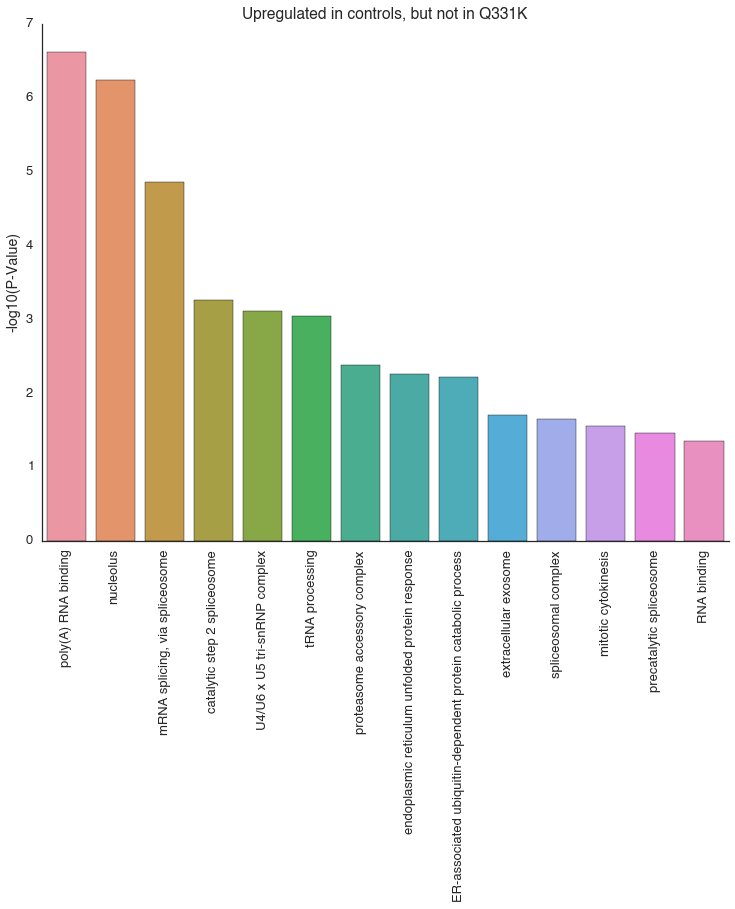

In [57]:
with dataviz.Figure(os.path.join(img_dir, "go_q331k_vs_control_change_upregulated.svg"), figsize=(20, 20)) as fig:
    ax = fig.add_subplot(2,2,1)

    sns.barplot(go_expressed_in_ctrl_but_not_q33k1_upregulated['GO Term Description'].values, 
                go_expressed_in_ctrl_but_not_q33k1_upregulated['log10_p_val'],
               ax=ax,
               )
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    ax.set_ylabel("-log10(P-Value)")
    ax.set_title("Upregulated in controls, but not in Q331K")
    sns.despine()

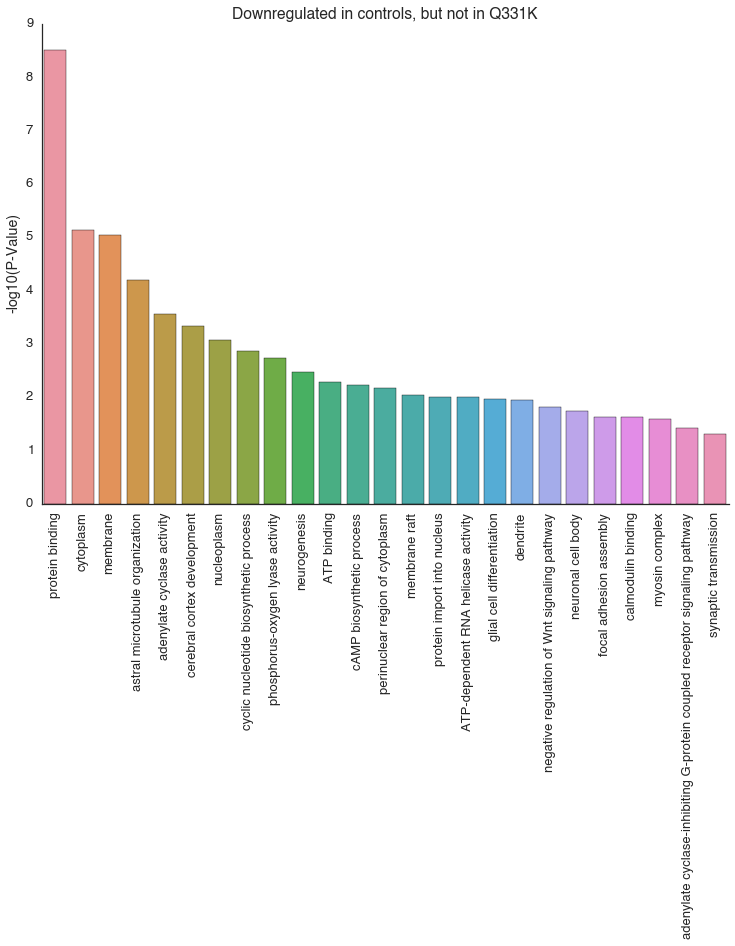

In [58]:
with dataviz.Figure(os.path.join(img_dir, "go_q331k_vs_control_change_downregulated.svg"), figsize=(20, 20)) as fig:
    ax = fig.add_subplot(2,2,1)

    sns.barplot(go_expressed_in_ctrl_but_not_q33k1_downregulated['GO Term Description'].values, 
                go_expressed_in_ctrl_but_not_q33k1_downregulated['log10_p_val'],
               ax=ax,
               )
    [tick.set_rotation(90) for tick in ax.get_xticklabels()]
    ax.set_ylabel("-log10(P-Value)")
    ax.set_title("Downregulated in controls, but not in Q331K")
    sns.despine()

#Try Optimal Leaf Ordering and PCA Clustering

In [59]:
foo = unstressed_protein_coding_pca.components_.copy()

In [60]:
foo.columns = [ensembl_id_to_name[item] for item in foo]

In [61]:
foo.ix['pc_2'].sort_values()[-100:]

Baiap2           0.015228
H2afy            0.015231
Prelp            0.015242
Gm21887          0.015253
Nav2             0.015255
Rrs1             0.015257
Col1a1           0.015270
Fxn              0.015278
Lcp2             0.015298
Trip10           0.015300
Etv5             0.015310
Rbm42            0.015334
Cdc42ep1         0.015363
Nosip            0.015384
Gpr56            0.015387
Rcc2             0.015391
Mcm10            0.015391
Mdm1             0.015397
Notch1           0.015408
Rnf26            0.015414
Rpl8             0.015424
Vmn1r183         0.015446
Gpr6             0.015446
Ier5             0.015465
Kcnj4            0.015466
Eno1b            0.015469
Bag3             0.015485
Tubb4b           0.015486
Npm3             0.015513
Kif2c            0.015519
                   ...   
Artn             0.015846
Shmt2            0.015858
Atic             0.015862
Pml              0.015868
Eftud2           0.015873
Tkt              0.015875
2310001K24Rik    0.015876
Zhx2        

In [62]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

def leaves(t, t2=None):
    """ Returns the leaves of a ClusterNode """
    try:
        return t.pre_order()
    except AttributeError:
        if t2 is not None:
            return t2.pre_order()
        else:
            return []

# For an element x, returns the set that x isn't in
other = lambda x, V, W: W if x in V else V
M = {}

def optimal_scores(v, D, fast=True):
    """ Implementation of Ziv-Bar-Joseph et al.'s leaf order algorithm
    v is a ClusterNode
    D is a distance matrix """
    def score_func(left, right, u, m, w, k):
        return Mfunc(left, u, m) + Mfunc(right, w, k) + D[m, k]
    
    def Mfunc(v, a, b):
        if a == b:
            M[v, a, b] = 0
        return M[v, a, b]
    
    if v.is_leaf():
        n = v.get_id()
        M[v, n, n] = 0
        return 0
    else:
        L = leaves(v.left)
        R = leaves(v.right)
        LL = leaves(v.left.left, v.left)
        LR = leaves(v.left.right, v.left)
        RL = leaves(v.right.left, v.right)
        RR = leaves(v.right.right, v.right)
        for l in L:
            for r in R:
                M[v.left, l, r] = slow_optimal_scores(v.left, D)
                M[v.right, l, r] = slow_optimal_scores(v.right, D)
                for u in L:
                    for w in R:
                        if fast:
                            m_order = sorted(other(u, LL, LR), key=lambda m: Mfunc(v.left, u, m))
                            k_order = sorted(other(w, RL, RR), key=lambda k: Mfunc(v.right, w, k))
                            C = min([D[m, k] for m in other(u, LL, LR) for k in other(w, RL, RR)])
                            Cmin = 1e10
                            for m in m_order:
                                if M[v.left, u, m] + M[v.right, w, k_order[0]] + C >= Cmin:
                                    break
                                for k in k_order:
                                    if M[v.left, u, m] + M[v.right, w, k] + C >= Cmin:
                                        break
                                    C = score_func(v.left, v.right, u, m, w, k)
                                    if C < Cmin:
                                        Cmin = C
                            M[v, u, w] = M[v, w, u] = Cmin
                        else:
                            M[v, u, w] = M[v, w, u] = \
                                min([score_func(v.left, v.right, u, m, w, k) \
                                    for m in other(u, LL, LR) \
                                    for k in other(w, RL, RR)])
                return M[v, l, r]

slow_optimal_scores = lambda v, D: optimal_scores(v, D, fast=False)
fast_optimal_scores = lambda v, D: optimal_scores(v, D, fast=True)

def order_tree(v, D, fM=None, scores=slow_optimal_scores):
    """ Returns an optimally ordered tree """
    # Generate scores the first pass
    if fM is None:
        fM = 1
        scores(v, D)
    
    L = leaves(v.left)
    R = leaves(v.right)
    if len(L) and len(R):
        u, w = min([(u, w) for u in L for w in R], key=lambda (u,w): M[v, u, w])
        if w in leaves(v.right.left):
            v.right.right, v.right.left = v.right.left, v.right.right
        if u in leaves(v.left.right):
            v.left.left, v.left.right = v.left.right, v.left.left
        v.left = order_tree(v.left, D, fM)
        v.right = order_tree(v.right, D, fM)
    return v

In [63]:
@property
def reordered_ind(self):
    M = {}
    tree = hierarchy.to_tree(self.linkage)
    dists = distance.squareform(distance.pdist(self.array, metric=self.metric))
    return leaves(order_tree(tree, dists))

sns.matrix._DendrogramPlotter.reordered_ind = reordered_ind

In [64]:
#old_ind = sns.matrix._DendrogramPlotter.reordered_ind

In [65]:
#sns.clustermap(np.log10(unstressed_rpkm_df[bar]).fillna(0))
num_loadings = -1 * 50
#bar = list(set(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values()[:100].index) | set(unstressed_protein_coding_pca.components_.ix['pc_1'].sort_values()[:100].index))
bar = list(set(unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values()[num_loadings:].index) | set(unstressed_protein_coding_pca.loadings.ix['pc_1'].sort_values()[num_loadings:].index))
pc2_genes = set(unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values()[num_loadings:].index)
pc1_genes = set(unstressed_protein_coding_pca.loadings.ix['pc_1'].sort_values()[num_loadings:].index)

In [66]:
unstressed_rpkm_df = rpkm_df.xs(False, level="stress").xs("june", level="date")
zscore = (unstressed_rpkm_df[bar] - unstressed_rpkm_df[bar].mean()).div(unstressed_rpkm_df[bar].std())

In [67]:
ordering = ["AV_cont_rev_a", "AV_cont_rev_b", "AV_cont_gt_a", "AV_cont_gt_b", "AV_cont_hWT_A", "AV_cont_hWT_b", "AV_cont_q331k_A", "AV_cont_q331k_b",]
zscore = zscore.reindex(ordering, level='exp')

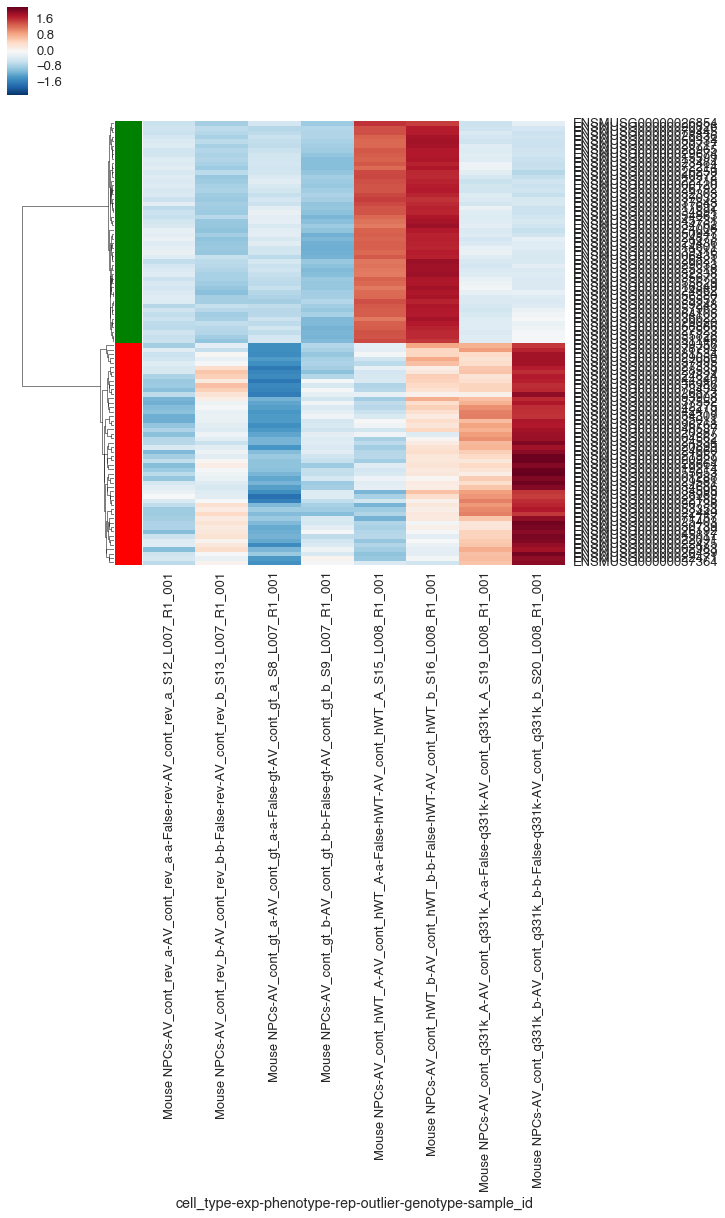

In [68]:
clustergrid = sns.clustermap(zscore.T, col_cluster=False, row_colors=['g' if gene in pc1_genes else 'r' for gene in zscore.columns])

#Fisher Exact Test for differental Enrichment between gene sets

In [69]:
for name, x in mm10GO.GO.iterrows():
    pc1_overlap = len(x['Ensembl Gene ID'] & pc1_genes)
    pc2_overlap = len(x['Ensembl Gene ID'] & pc2_genes)
    
    if pc1_overlap > 0:
        pass
        #print pc1_overlap, pc2_overlap
    pc1_not_overlap = len(pc1_genes) - pc1_overlap
    pc2_not_overlap = len(pc2_genes) - pc2_overlap
    
    
    pval = scipy.stats.fisher_exact([[pc1_overlap, pc2_overlap], [pc1_not_overlap, pc2_not_overlap]])
    if pval < .05:
        print row

#Regular GO Enrichment

In [70]:
result = mm10GO.enrichment(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values()[-100:].index).dropna()
result = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [71]:
result

GO Term Description  \
GO Term Accession                                                      
GO:0005515                                           protein binding   
GO:0005737                                                 cytoplasm   
GO:0045892         negative regulation of transcription, DNA-temp...   
GO:0005654                                               nucleoplasm   
GO:0045668         negative regulation of osteoblast differentiation   
GO:0071260                  cellular response to mechanical stimulus   
GO:0035019                  somatic stem cell population maintenance   
GO:0042802                                 identical protein binding   
GO:0000122         negative regulation of transcription from RNA ...   
GO:0005634                                                   nucleus   
GO:0005730                                                 nucleolus   
GO:0043209                                             myelin sheath   
GO:0044822                                       poly(A) RNA binding   
GO:0030426                                               growth cone   
GO:0007605                               sensory perception of sound   
GO:0042127                          regulation of cell proliferation   
GO:0007420                                         brain development   

                   Bonferroni-corrected Hypergeometric p-Value  \
GO Term Accession                                                
GO:0005515                                            0.000002   
GO:0005737                                            0.000037   
GO:0045892                                            0.000074   
GO:0005654                                            0.000074   
GO:0045668                                            0.000087   
GO:0071260                                            0.000093   
GO:0035019                                            0.000139   
GO:0042802                                            0.000227   
GO:0000122                                            0.000271   
GO:0005634                                            0.000495   
GO:0005730                                            0.000886   
GO:0043209                                            0.001333   
GO:0044822                                            0.002548   
GO:0030426                                            0.013110   
GO:0007605                                            0.017179   
GO:0042127                                            0.025354   
GO:0007420                                            0.045059   

                   N Genes in List and GO Category  \
GO Term Accession                                    
GO:0005515                                      75   
GO:0005737                                      46   
GO:0045892                                      12   
GO:0005654                                      25   
GO:0045668                                       4   
GO:0071260                                       5   
GO:0035019                                       4   
GO:0042802                                      12   
GO:0000122                                      13   
GO:0005634                                      41   
GO:0005730                                      13   
GO:0043209                                       6   
GO:0044822                                      15   
GO:0030426                                       4   
GO:0007605                                       4   
GO:0042127                                       5   
GO:0007420                                       5   

                   N Expressed Genes in GO Category  N Genes in GO category  \
GO Term Accession                                                             
GO:0005515                                    10690                   10690   
GO:0005737                                     5296                    5296   
GO:0045892                                      542                     542   
GO:

In [72]:
result = mm10GO.enrichment(unstressed_protein_coding_pca.components_.ix['pc_2'].sort_values()[:100].index).dropna()
result = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [73]:
result

GO Term Description  \
GO Term Accession                                                      
GO:0002092           positive regulation of receptor internalization   
GO:0005794                                           Golgi apparatus   
GO:0070062                                     extracellular exosome   
GO:0042787         protein ubiquitination involved in ubiquitin-d...   
GO:0005802                                       trans-Golgi network   
GO:0061630                         ubiquitin protein ligase activity   
GO:0005765                                        lysosomal membrane   
GO:0005515                                           protein binding   
GO:0032403                                   protein complex binding   
GO:0005770                                             late endosome   
GO:0000139                                            Golgi membrane   
GO:0015031                                         protein transport   
GO:0048471                           perinuclear region of cytoplasm   
GO:0006974                  cellular response to DNA damage stimulus   
GO:0010468                             regulation of gene expression   
GO:0008134                              transcription factor binding   
GO:0006511             ubiquitin-dependent protein catabolic process   
GO:0004871                                signal transducer activity   
GO:0005737                                                 cytoplasm   

                   Bonferroni-corrected Hypergeometric p-Value  \
GO Term Accession                                                
GO:0002092                                            0.000005   
GO:0005794                                            0.000059   
GO:0070062                                            0.001775   
GO:0042787                                            0.002528   
GO:0005802                                            0.002545   
GO:0061630                                            0.002809   
GO:0005765                                            0.003579   
GO:0005515                                            0.005267   
GO:0032403                                            0.013890   
GO:0005770                                            0.016291   
GO:0000139                                            0.020907   
GO:0015031                                            0.022094   
GO:0048471                                            0.026352   
GO:0006974                                            0.029749   
GO:0010468                                            0.033585   
GO:0008134                                            0.037757   
GO:0006511                                            0.038091   
GO:0004871                                            0.042982   
GO:0005737                                            0.045461   

                   N Genes in List and GO Category  \
GO Term Accession                                    
GO:0002092                                       4   
GO:0005794                                      15   
GO:0070062                                      26   
GO:0042787                                       4   
GO:0005802                                       5   
GO:0061630                                       6   
GO:0005765                                       6   
GO:0005515                                      67   
GO:0032403                                       6   
GO:0005770                                       4   
GO:0000139                                       7   
GO:0015031                                       8   
GO:0048471                                       9   
GO:0006974                                       5   
GO:0010468                                       5   
GO:0008134                                       6   
GO:0006511                                       4   
GO:0004871                                       4   
GO:0005737                                      38   

              

#Hacked Version of GSEA
http://www.pnas.org/content/102/43/15545.full.pdf?with-ds=yes

My phneotype and ranking are going to be the PCs 1 and 2

In [74]:
pc2 = unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values(ascending=False)
large_sets = mm10GO.GO[(mm10GO.GO['nGenes'] > 25) & (mm10GO.GO['nGenes'] < 500)] 

In [75]:
result = {}
in_set = {}
for name, genes in large_sets['Ensembl Gene ID'].iteritems():
    result[name] = pc2.copy()
    in_set[name] = {gene_id: True for gene_id in genes}

result = pd.DataFrame(result)
in_set = pd.DataFrame(in_set)
in_set = in_set.fillna(False)

incomplete_in_set = in_set.T

for gene in result.index.difference(in_set.index):
    incomplete_in_set[gene] = False
    
in_set = incomplete_in_set[result.index].T

#is_set = in_set.reindex(result.index, fill_value=False)

hit_values = result.copy()
miss_values = result.copy()

In [76]:
hit_values[~in_set] = 0
hit_values = np.abs(hit_values)
miss_values[:] = 0
miss_values[~in_set] = 1

In [77]:
def enrichment_score_vectorized(hit_values, miss_values):
    normalized_hit_values = hit_values / hit_values.sum()
    normalized_miss_values = miss_values / miss_values.sum()

    enrichment_score = normalized_hit_values.cumsum() - normalized_miss_values.cumsum()
    return enrichment_score

def get_largest_score_vectorized(enrichment_score):
    combined_scores = pd.concat({"max_score": enrichment_score.max(), "min_score": enrichment_score.min()}).unstack()
    return combined_scores.apply(lambda x: x.max_score if np.abs(x.max_score) > np.abs(x.min_score) else x.min_score, axis=0)

In [78]:
enrichment_score = enrichment_score_vectorized(hit_values, miss_values)

In [79]:
largest_enrichment = get_largest_score_vectorized(enrichment_score)

In [118]:
results = {}
for x in range(1000):
    index = list(hit_values.index)
    #np.random.shuffle(df.index.get_values())
    random.shuffle(index)
    shuffled_hit_values = hit_values.copy().ix[index]
    shuffled_miss_values = miss_values.copy().ix[index]

    shuffled_hit_values.reset_index()
    shuffled_miss_values.reset_index()
    results[x] = get_largest_score_vectorized(enrichment_score_vectorized(shuffled_hit_values, shuffled_miss_values))
shuffled_results = pd.concat(results).unstack()

In [170]:
#Compute p-values as in paper, generated z-scores based on only positive or negative distributions

pos_enrichment = largest_enrichment[largest_enrichment >= 0]
neg_enrichment = largest_enrichment[largest_enrichment < 0]

pos_shuffled = shuffled_results[pos_enrichment.index]
neg_shuffled = shuffled_results[neg_enrichment.index]

pos_shuffled = pos_shuffled[pos_shuffled >= 0]
neg_shuffled = neg_shuffled[neg_shuffled < 0]

# pos_z_score = (pos_enrichment - pos_shuffled.mean()) / pos_shuffled.std()
# neg_z_score = (neg_enrichment - neg_shuffled.mean()) / neg_shuffled.std()
# p_values = np.abs(pd.concat([pos_z_score, neg_z_score])).apply(scipy.stats.norm.sf)
pos_count = pos_shuffled.count()
neg_count = neg_shuffled.count()

pos_p_value = (pos_shuffled > pos_enrichment).sum() / pos_count
neg_p_value = (neg_shuffled < neg_enrichment).sum() / neg_count
p_values = np.abs(pd.concat([pos_p_value, neg_p_value]))

In [171]:
p_values

GO:0000049    0.000000
GO:0000060    0.000000
GO:0000077    0.000000
GO:0000082    0.000000
GO:0000086    0.001961
GO:0000118    0.141667
GO:0000165    0.000000
GO:0000166    0.000000
GO:0000183    0.003861
GO:0000184    0.007874
GO:0000226    0.000000
GO:0000228    0.000000
GO:0000278    0.001976
GO:0000381    0.003906
GO:0000387    0.000000
GO:0000398    0.000000
GO:0000413    0.120000
GO:0000723    0.000000
GO:0000724    0.000000
GO:0000775    0.000000
GO:0000776    0.000000
GO:0000777    0.000000
GO:0000781    0.039666
GO:0000784    0.000000
GO:0000785    0.000000
GO:0000786    0.002053
GO:0000790    0.000000
GO:0000792    0.000000
GO:0000793    0.000000
GO:0000794    0.000000
                ...   
GO:0071385    0.044266
GO:0071392    0.059322
GO:0071456    0.000000
GO:0071549    0.000000
GO:0071773    0.022634
GO:0071805    0.005825
GO:0071902    0.002041
GO:0072562    0.000000
GO:0072593    0.009709
GO:0072659    0.000000
GO:0086010    0.075875
GO:0090002    0.098299
GO:0090090 

In [176]:
bf_corrected_p_values = p_values * len(p_values)
#bf_corrected_p_values = bf_corrected_p_values[bf_corrected_p_values < .05]
#bf_corrected_p_values = bf_corrected_p_values.sort_values()

In [122]:
# #Error checking

#Make sure all the numbers line up / rows are correctly aligned
# print len(in_set.columns), len(result.columns)
# print len(result) , len(in_set)
# print len(result), len(pc2.index), len(hit_values), len(miss_values)

#
# foo = gsea(pc2, mm10GO.GO.ix['GO:2001244']['Ensembl Gene ID'])
# print hit_values.sum()['GO:2001244']

# #This tells me that the miss rate is correct
# print len(set(pc2.index) - mm10GO.GO.ix['GO:2001244']['Ensembl Gene ID'])
# print miss_values.sum()['GO:2001244']

In [84]:
def gsea(ordered_genes, genes_in_set):
    genes_in_set = set(ordered_genes.index) & set(genes_in_set)
   
    p_hit = 0
    p_miss = 0
    enrichment_score = []
    print len(genes_in_set)
    total_miss = len(set(ordered_genes.index) - genes_in_set) * 1.0
    
    ordered_genes = np.abs(ordered_genes)
    total_hit = ordered_genes.ix[genes_in_set].sum() * 1.0

    for gene, value in ordered_genes.iteritems():
        if gene in genes_in_set:
            p_hit += value / total_hit
        else:
            p_miss += 1 / total_miss
        enrichment_score.append(p_hit - p_miss)
    print total_hit, total_miss
    #print p_hit, p_miss
    return enrichment_score    

def get_max_score_from_enrichment(enrichment_scores):
    max_score = np.max(np.abs(enrichment_scores))
    if max_score in enrichment_scores:
        return max_score
    elif max_score * -1.0 in enrichment_scores:
        return max_score * -1.0
    else:
        return "error"
        
def shuffle(df):
    index = list(df.index)
    np.random.shuffle(df.index.get_values())
    #random.shuffle(index)
    df = df.ix[index]
    df.reset_index()
    return df

def compute_one_tailed_p_value(max_scores):
    if x < 0:
        foo = max_scores[max_scores <= 0]
        z_score = (x - foo.mean()) / foo.std()
        #print foo.mean(), foo.std()

    if x > 0:
        foo = max_scores[max_scores >= 0]
        z_score = (x - foo.mean()) / foo.std()
        #print foo.mean(), foo.std()
        
    p_value = scipy.stats.norm.sf(abs(z_score))
    return p_value

# pc2 = unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values(ascending=False)

# for name, gene_set in large_sets['Ensembl Gene ID'].iteritems():
#     real_score = get_max_score_from_enrichment(gsea(pc2, gene_set))

#     shuffled_scores = []
#     for x in range(200):
#         shuffled_scores.append(get_max_score_from_enrichment(gsea(shuffle(pc2), gene_set)))
#     shuffled_scores = np.array(shuffled_scores) 

#     print mm10GO.GO.ix[name]['GO Term Name'], name, real_score, compute_one_tailed_p_value(real_score, shuffled_scores), len(gene_set)

In [85]:
# pc2 = unstressed_protein_coding_pca.loadings.ix['pc_2'].sort_values(ascending=False)

# gene_set = mm10GO.GO.ix['GO:0000165']['Ensembl Gene ID']
# real_score = gsea(pc2, gene_set)
# #real_score = get_max_score_from_enrichment(gsea(pc2, gene_set))

# # shuffled_scores = []
# # for x in range(100):
# #     shuffled_scores.append(get_max_score_from_enrichment(gsea(shuffle(pc2), gene_set)))
# # shuffled_scores = np.array(shuffled_scores) 

In [177]:
enrichment_df = pd.concat({"enrichment": largest_enrichment, "p-val": bf_corrected_p_values}).unstack().T

In [178]:
enrichment_df

enrichment       p-val
GO:0000045   -0.463204    0.000000
GO:0000049    0.443232    0.000000
GO:0000060    0.518688    0.000000
GO:0000062   -0.397628    0.000000
GO:0000077    0.421911    0.000000
GO:0000082    0.442355    0.000000
GO:0000086    0.390917    2.607843
GO:0000118    0.257140  188.416667
GO:0000139   -0.409606    0.000000
GO:0000149   -0.452147    0.000000
GO:0000151   -0.471304    0.000000
GO:0000165    0.277603    0.000000
GO:0000166    0.348843    0.000000
GO:0000183    0.303861    5.135135
GO:0000184    0.381157   10.472441
GO:0000186   -0.319365    7.838900
GO:0000187   -0.295858    0.000000
GO:0000209   -0.416254    0.000000
GO:0000226    0.316224    0.000000
GO:0000228    0.438310    0.000000
GO:0000278    0.407744    2.628458
GO:0000287   -0.249346    0.000000
GO:0000381    0.390132    5.195312
GO:0000387    0.523234    0.000000
GO:0000398    0.507943    0.000000
GO:0000407   -0.479557    0.000000
GO:0000413    0.220013  159.600000
GO:0000422   -0.512578    0.000000
GO:0000502   -0.244030    5.341365
GO:0000723    0.509317    0.000000
...                ...         ...
GO:0090502    0.402961    0.000000
GO:0090575    0.428447    0.000000
GO:0090630   -0.259121   90.803213
GO:0097110    0.276938   21.494949
GO:0097190    0.281938    5.462012
GO:0097191    0.299328   18.808081
GO:0097192    0.257396  126.282828
GO:0097481   -0.208294   63.712575
GO:0098655   -0.283528    0.000000
GO:0098656   -0.223117   61.384615
GO:0098779   -0.231040    0.000000
GO:1900026   -0.324743   43.164300
GO:1901215    0.297930   18.657315
GO:1901998   -0.234889  142.304527
GO:1902476   -0.341009    0.000000
GO:1902600   -0.393145    0.000000
GO:1903146    0.402108    2.686869
GO:1903506   -0.311048   32.112676
GO:1903507   -0.327802   84.950100
GO:1903561   -0.253363   29.555556
GO:1903955   -0.236261    5.195312
GO:1904030   -0.209281  404.188912
GO:1990090    0.362408   10.270270
GO:2000379    0.386784    5.611814
GO:2001235   -0.336974    2.719836
GO:2001237   -0.293869    5.541667
GO:2001238    0.409889    2.628458
GO:2001240    0.383946    2.543021
GO:2001243    0.263651  214.349515
GO:2001244    0.293862   55.306931

[1330 rows x 2 columns]

In [87]:
# heatmap_prep = pd.DataFrame(pc2.copy())
# heatmap_prep['in_set'] = heatmap_prep.index.isin(gene_set)
# heatmap_prep['x_loc'] = xrange(len(heatmap_prep))
# heatmap_prep['y_loc'] = heatmap_prep.in_set.apply(lambda x: 1 if x else 0)
# heatmap_prep = heatmap_prep.drop("pc_2", axis=1)
# plotter = heatmap_prep[heatmap_prep.in_set]

In [180]:
shuffled_results['GO:0032508']

0     -0.086793
1     -0.104156
2      0.150467
3      0.110627
4     -0.116782
5     -0.180975
6      0.196917
7      0.121279
8      0.148815
9      0.193796
10     0.118517
11    -0.195287
12    -0.205756
13    -0.333722
14     0.187220
15    -0.156006
16    -0.114350
17     0.127338
18    -0.089293
19     0.147385
20     0.140623
21     0.128340
22     0.187784
23     0.113845
24    -0.231606
25    -0.315020
26     0.170929
27    -0.152074
28     0.123571
29    -0.100979
         ...   
970   -0.142758
971   -0.113162
972    0.229801
973    0.126193
974    0.183695
975   -0.132936
976    0.096035
977   -0.331017
978    0.252991
979    0.122020
980    0.133477
981   -0.237545
982    0.151970
983   -0.164025
984   -0.211049
985   -0.156092
986   -0.115939
987   -0.146986
988    0.090158
989   -0.284167
990   -0.263329
991    0.184291
992    0.138508
993    0.223865
994    0.112975
995    0.126188
996    0.168670
997   -0.150649
998   -0.148413
999   -0.106846
Name: GO:0032508, dtype:

In [179]:
HTML(enrichment_df[enrichment_df['p-val'] < .05].sort_values("enrichment", ascending=False).dropna().to_html())

In [181]:
enrichment_df[enrichment_df['p-val'] < .05].sort_values("enrichment", ascending=False)

enrichment  p-val
GO:0032508    0.692950      0
GO:0000793    0.652679      0
GO:0071013    0.612417      0
GO:0006260    0.575123      0
GO:0006418    0.563627      0
GO:0004812    0.563627      0
GO:0006310    0.555189      0
GO:0070491    0.551999      0
GO:0007059    0.545279      0
GO:0008026    0.536232      0
GO:0005681    0.529172      0
GO:0071479    0.524248      0
GO:0000387    0.523234      0
GO:0006284    0.522388      0
GO:0032040    0.521891      0
GO:0000777    0.520370      0
GO:0000060    0.518688      0
GO:0051276    0.515933      0
GO:0000723    0.509317      0
GO:0072332    0.507986      0
GO:0000398    0.507943      0
GO:0035861    0.506010      0
GO:0005871    0.503599      0
GO:0002548    0.503205      0
GO:0031492    0.495684      0
GO:0006325    0.495262      0
GO:0000775    0.495230      0
GO:0005719    0.492338      0
GO:0032543    0.490085      0
GO:0010212    0.489698      0
...                ...    ...
GO:0004190   -0.480020      0
GO:0006885   -0.483302      0
GO:0005765   -0.485003      0
GO:0007631   -0.485273      0
GO:0031648   -0.486160      0
GO:0005770   -0.486255      0
GO:0030433   -0.487481      0
GO:0042787   -0.488963      0
GO:0005801   -0.497328      0
GO:0035115   -0.504871      0
GO:0010508   -0.505601      0
GO:0006904   -0.511643      0
GO:0000422   -0.512578      0
GO:0016747   -0.512675      0
GO:0016192   -0.512869      0
GO:0032008   -0.521077      0
GO:0055072   -0.521978      0
GO:0033116   -0.525835      0
GO:0031902   -0.534588      0
GO:0061631   -0.541278      0
GO:0007040   -0.541679      0
GO:0030117   -0.543611      0
GO:0006888   -0.545111      0
GO:0030670   -0.551467      0
GO:0009306   -0.557090      0
GO:0031016   -0.558577      0
GO:0005484   -0.577187      0
GO:0031201   -0.588519      0
GO:0019003   -0.605828      0
GO:0046854   -0.607039      0

[635 rows x 2 columns]

In [182]:
enrichment_df = enrichment_df.join(mm10GO.GO)
# enrichment_df[enrichment_df.enrichment > 0].sort_values("enrichment", ascending=False).dropna()

In [183]:
# enrichment_df[enrichment_df.enrichment > 0].sort_values("enrichment", ascending=False).dropna()

In [184]:
go_term = 'GO:0032508'

In [185]:
genes_in_set = pd.DataFrame(hit_values[go_term].copy())
genes_in_set['x_loc'] = xrange(len(genes_in_set))
genes_in_set['y_loc'] = genes_in_set[go_term].apply(lambda x: 1 if x > 0 else 0)
genes_in_set = genes_in_set[genes_in_set.y_loc == 1]

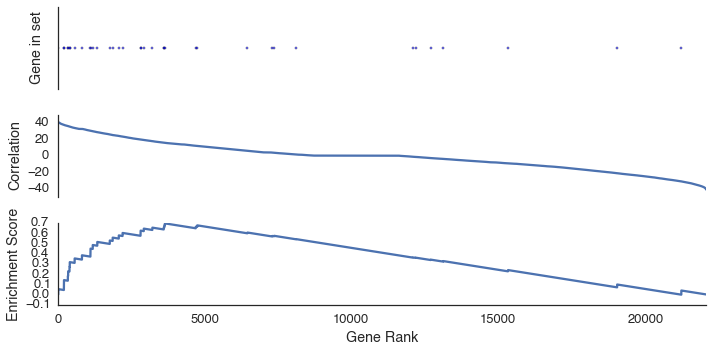

In [188]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(10, 5)) as fig:
    
    ax = fig.add_subplot(3,1,1)
    ax.scatter(genes_in_set.x_loc, genes_in_set.y_loc, s=5, alpha=.6)
    ax.set_xlim(0, len(enrichment_score[go_term]))
    sns.despine(ax=ax, left=False, bottom=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel("Gene in set")
    
    ax = fig.add_subplot(3,1,2)
    ax.plot(pc2)
    ax.set_xlim(0, len(enrichment_score[go_term]))
    sns.despine(ax=ax, bottom=True)
    ax.set_xticklabels([])
    ax.set_ylabel("Correlation")
    
    ax = fig.add_subplot(3,1,3)
    ax.plot(enrichment_score[go_term])
    sns.despine(ax=ax)
    ax.set_xlim(0, len(enrichment_score[go_term]))
    ax.set_ylabel("Enrichment Score")
    ax.set_xlabel("Gene Rank")

Create random sets 
create a pesudo order and ranking 

#Compare humanized with mutant and both with the mouse controls

In [96]:
unstressed_comparison = pd.concat({(os.path.basename(item).split("_")[0], os.path.basename(item).split("_")[2]): pd.read_csv(item, index_col=0) for item in  glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/*unstressed.csv")})
unstressed_comparison.index.names = ['genotype_1', 'genotype_2', 'gene_id']
unstressed_comparison['gene_id'] = unstressed_comparison.index.get_level_values(level="gene_id")

sig_unstressed_comparison = unstressed_comparison[(unstressed_comparison.padj <= .05)  & (abs(unstressed_comparison.log2FoldChange) > np.log2(1.5))]
sig_unstressed_comparison_upregulated = sig_unstressed_comparison[sig_unstressed_comparison.log2FoldChange > 0]
sig_unstressed_comparison_downregulated = sig_unstressed_comparison[sig_unstressed_comparison.log2FoldChange < 0]


In [97]:
pd.concat({"upregulated": sig_unstressed_comparison_upregulated.groupby(level=["genotype_1", 'genotype_2']).count().baseMean,
           "downregulated": sig_unstressed_comparison_downregulated.groupby(level=["genotype_1", 'genotype_2']).count().baseMean})

               genotype_1  genotype_2
downregulated  hWT         gt            483
                           rev           328
               q331k       gt            273
                           hWT           637
                           rev            29
               rev         gt             67
upregulated    hWT         gt            783
                           rev           634
               q331k       gt             24
                           hWT           285
                           rev             3
               rev         gt              3
Name: baseMean, dtype: int64

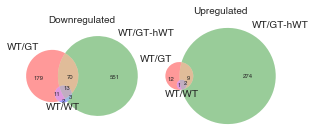

In [98]:
with dataviz.Figure(os.path.join(img_dir, "unstressed_all_changes.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([sig_unstressed_comparison_downregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_downregulated.ix['q331k', 'hWT'].index,
                  sig_unstressed_comparison_downregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([sig_unstressed_comparison_upregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_upregulated.ix['q331k', 'hWT'].index,
                  sig_unstressed_comparison_upregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn2.py:132: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


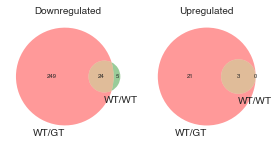

In [99]:
with dataviz.Figure(os.path.join(img_dir, "unstressed_q33k1_comparisons.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn2([sig_unstressed_comparison_downregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_downregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn2([sig_unstressed_comparison_upregulated.ix['q331k', 'gt'].index,
                  sig_unstressed_comparison_upregulated.ix['q331k', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

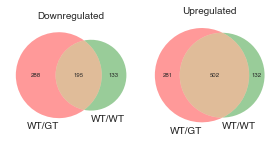

In [100]:
with dataviz.Figure(os.path.join(img_dir, "unstressed_hWT_comparisons.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn2([sig_unstressed_comparison_downregulated.ix['hWT', 'gt'].index,
                  sig_unstressed_comparison_downregulated.ix['hWT', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn2([sig_unstressed_comparison_upregulated.ix['hWT', 'gt'].index,
                  sig_unstressed_comparison_upregulated.ix['hWT', 'rev'].index,],
            set_labels=map(lambda x: names[x], ("gt", "rev")),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

Looks like it might be a loss of function? That could explain why the Q331k Mutation has fewer changes than the humanized version?

downregulated q331k hWT           637
upregulated   q331k hWT           285


In [101]:
def plot_both_changing(genotype_1, vs_1, genotype_2, vs_2, outfile):
    significantly_enriched_genes_either = sig_unstressed_comparison.ix[genotype_1, vs_1].index.get_level_values(level="gene_id") | sig_unstressed_comparison.ix[genotype_2, vs_2].index.get_level_values(level="gene_id")
    changing_in_either = unstressed_comparison[unstressed_comparison.gene_id.isin(significantly_enriched_genes_either)].log2FoldChange.unstack()
    print len(significantly_enriched_genes_either)
    with dataviz.Figure(outfile, figsize=(4, 4)) as fig:
        ax = fig.add_subplot(1,1,1)
        KA, WT, middle = ['r','b', 'g']
        ka_genes = sig_unstressed_comparison.ix[genotype_1, vs_1].index.get_level_values(level="gene_id")
        wt_genes = sig_unstressed_comparison.ix[genotype_2, vs_2].index.get_level_values(level="gene_id")


        colors = []
        for gene in changing_in_either.columns:
            if gene in ka_genes and gene in wt_genes:
                colors.append(middle)
            elif gene in ka_genes:
                colors.append(KA)
            elif gene in wt_genes:
                colors.append(WT)

        ax.scatter(changing_in_either.ix[genotype_1, vs_1].values, changing_in_either.ix[genotype_2, vs_2].values, alpha=.7, 
                   color=colors, 
                   s=5)
        ax.set_xlabel("{} vs {} Log2 Fold Change".format(names[genotype_1], names[vs_1]), fontsize=10)
        ax.set_ylabel("{} vs {} Log2 Fold Change".format(names[genotype_2], names[vs_2]), fontsize=10)
        #ax.set_title("Differental Espression of WT vs KA Mutant")
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

        red_patch = mpatches.Patch(color='r', label="{} vs {}".format(names[genotype_1], names[vs_1]))
        blue_patch = mpatches.Patch(color='b', label="{} vs {}".format(names[genotype_2], names[vs_2]))
        green_patch = mpatches.Patch(color='g', label='Both')


        ax.legend(handles=[red_patch, blue_patch, green_patch], loc=0)
        sns.despine(ax=ax)

980


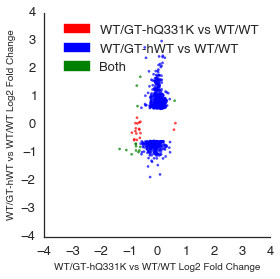

In [102]:
plot_both_changing('q331k', 'rev', 'hWT', 'rev', os.path.join(img_dir, "q331k_and_hwt_vs_rev.svg"))

300


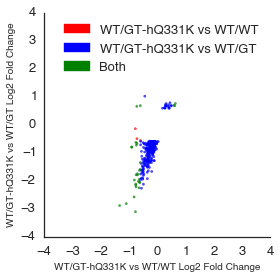

In [103]:
plot_both_changing('q331k', 'rev', 'q331k', 'gt', os.path.join(img_dir, "q331k_vs_rev_and_gt.svg"))

1531


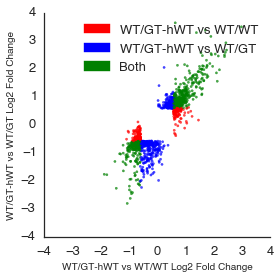

In [104]:
plot_both_changing('hWT', 'rev', 'hWT', 'gt', os.path.join(img_dir, "hWT_vs_rev_and_gt.svg"))

1366


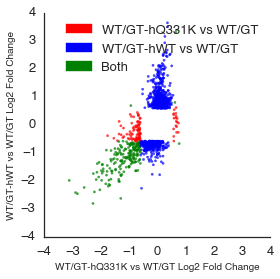

In [105]:
plot_both_changing('q331k', 'gt', 'hWT', 'gt', os.path.join(img_dir, "q331k_and_hwt_vs_gt.svg"))

980


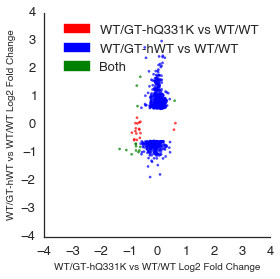

In [106]:
plot_both_changing('q331k', 'rev', 'hWT', 'rev', os.path.join(img_dir, "q331k_and_hwt_vs_rev.svg"))

#Generate Splicing Comparisons
Going overkill with all the SE events because fuck it, computation is cheap, I'll figure it out later.  

In [107]:
splicing_events = sorted(glob.glob("/projects/ps-yeolab2/for_anthony/analysis/av_mouse_stress_v3/miso/*"))

In [108]:
miso_commands = []
for rep1, rep2 in itertools.permutations(splicing_events, 2):
    outfile = os.path.join("/home/gpratt/projects/for_anthony/analysis/miso_out_v2/SE", os.path.basename(rep1) + "_vs_" + os.path.basename(rep2))
    #print os.path.basename(rep1), os.path.basename(rep2)
    miso_commands.append("compare_miso --compare-samples {} {} {}".format(os.path.join(rep1, "SE"), os.path.join(rep2, "SE"), outfile))

In [109]:
def eplouge(name,count, run_dir="/home/gpratt/projects/encode/analysis/idr_analysis_p_value/"):
    return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn=1
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime=4:00:00
cd {2}
echo "hello, starting"
""".format(name, count, run_dir)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

In [110]:
total = 0 
result = []
for cmd in miso_commands:
    total += 1
    result.append('cmd[{}]="{}"'.format(total, cmd))
    
with open(os.path.join("/home/gpratt/projects/for_anthony/scripts/", "miso_compare.sh"), 'w') as out_file:
    out_file.write(eplouge("miso_compare", total, "/home/gpratt/projects/for_anthony/analysis/miso_out_v2/" ))
    for line in result:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

#Now analyze all this ish...

Analysis has been moved to the splicing anlaysis notebook